In [213]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import pickle
import copy as cp
from math import *
import datetime as dt
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
#
import scipy
import scipy.integrate as integrate
from scipy.optimize import root
from scipy.optimize import least_squares
import numba
# stats
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson

In [214]:
# write list to binary file
def write2pickle(file, fname):
    # store list in binary file so 'wb' mode
    with open(fname, 'wb') as f:
        pickle.dump(file, f)
        print('Done writing list into a binary file')

# Read list to memory
def read_pickle(fname):
    # for reading also binary mode is important
    with open(fname, 'rb') as f:
        file = pd.read_pickle(f)
        return file

# Chech directories exit. Create if not
def check_dir_exist(path):
    if not os.path.isdir(path):
        os.makedirs(path, exist_ok=True)

In [215]:
# This is to enable inline displays
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Plot parameters
rcParams['figure.figsize'] = 6,4

# Seaborn settings for notebook
rc = {'lines.linewidth': 1.,
      'axes.titlesize': 14,
      'axes.labelsize': 14,
      'xtick.labelsize': 10,
      'ytick.labelsize': 10,
      'legend.fontsize': 10,
      'savefig.dpi': 300,
      'axes.facecolor': 'white'}
sns.set_context('notebook', rc=rc)
sns.set_style('ticks', rc=rc)

In [216]:
# Set colors
colormap = ['magenta',
           'darkcyan',
           'darkseagreen',
           'green',
           'royalblue',
           'orangered',
           'steelblue',
           'peru',
           'skyblue',
           'firebrick',
           'blue',
           'red']

colormap1 = [sns.color_palette("Paired")[1],
             sns.color_palette("muted")[1],
             sns.color_palette("colorblind")[2],
             sns.color_palette("muted")[0]]

colormap2 = [sns.color_palette("Paired")[9],
             sns.color_palette("colorblind")[8],
             sns.color_palette("colorblind")[9],
             sns.color_palette("muted")[4]]

# Set found stationary solutions

In [228]:
# Set changable model parameters
dir_sts = "stat_sols/"
# exec_file = dir_sts+"model_0_literature.py" # first reference
# exec_file = dir_sts+"model_1_demethylated.py" # after demethylation (first estimation)
exec_file = dir_sts+"model_2_intact.py" # intact (second estimation)
# exec_file = dir_sts+"model_2_intact_azaC.py" # intact+azaC (second estimation)

# Execute from file
exec(open(exec_file).read())

In [229]:
# Set directories
dir_save = dir_data+"save/"
dir_pic = dir_data+"pic/"

# chech directories exit, create if not
check_dir_exist(dir_save)
check_dir_exist(dir_pic)
check_dir_exist(dir_pic+"svg/")

# Set model

In [230]:
# Wild type values
awt = 5.33e9  # characteristic number of ATP
Lwt = 1064.   # number of LINE-1 in wild type
Swt = 13243.  # number of SINE in wild type

### Constants: ###
Ng       = 3.08e9  # total genome size [bp]
Q        = 3804.   # number of housekeeping genes
nq       = 431.    # median HeLa cell protein length [aa]
nQ       = 1300.   # median HeLa housekeeping gene length [bp]
nL       = 6000.   # LINE-1 length [bp]
nS       = 300.    # SINE length [bp]
Naa      = 5.      # number of ATP molecules for adding a.a. [m.p.c. - mol. per cell]
Nnt      = 15.     # number of ATP molecules for adding nt. [m.p.c.]
tdiv     = 22.*60  # HeLa cell cycle duration, in minutes [min] ( == 1320 min )

### Parameter values: ###
rtot     = 9.5e6   # total number of ribosomes [m.p.c.]
Xi_max_L = 840.    # maximal integration elongation rate of one LINE-1 transposon [bp/(m.p.c.*min)]
Xi_max_S = 840.    # maximal integration elongation rate of one SINE transposon [bp/(m.p.c.*min)]
K_Xi_L   = 1.1e7   # integration elongation threshold of LINE-1 transposons [m.p.c.]
K_Xi_S   = 1.1e7   # integration elongation threshold of SINE transposons [m.p.c.]
KL       = 2.24e-3 # association constant of LINE-1 mRNA with ORF1p [1/m.p.c.]
wq       = 4.64    # maximal transcription rate of one gene [m.p.c./min]
wL       = 1.      # maximal transcription rate of one LINE-1 [m.p.c./min]
wS       = 20.     # maximal transcription rate of one SINE [m.p.c./min]
Th_nr_q  = 3.8e9   # transcription threshold of one gene [m.p.c.]
Th_nr_L  = 3.8e9   # transcription threshold of one LINE-1 [m.p.c.]
Th_nr_S  = 3.8e9   # transcription threshold of one SINE [m.p.c.]
gm_max_q = 300.    # maximal translation rate of q-RNA (aa/min) [a.a./(m.p.c.*min)]
gm_max_L = 300.    # maximal translation rate of LINE-1 RNA (aa/min) [a.a./(m.p.c.*min)]
K_gm_q   = 25900.  # translation threshold of one q-RNA [m.p.c.]
K_gm_L   = 25900.  # translation threshold of one LINE-1 RNA [m.p.c.]
k_bq     = 5e-8    # 2.7e-2 # cq complexes binding rate constant (diffusion limit) [1/(m.p.c.*min)]
k_bL     = 5e-8    # 2.7e-2 # cL complexes binding rate constant (diffusion limit) [1/(m.p.c.*min)]
k_uq     = 1e-2    # 1e3 # cq complexes unbinding rate constant
k_uL     = 1e-2    # 1e3 # cL complexes unbinding rate constant
k_subS   = 5e-8    # 6e-8 # bS formation (ORFp2+mS) substitution of mL
k_subL   = 5e-6    # 6e-8 # bL formation (ORFp2+mL) substitution of mS
d_mq     = 1.15e-3 # q-RNAs degradation rate constant [1/min]
d_cq     = 1.55e-3 # cq complexes degradation rate constant [1/min]
d_q      = 5.67e-4 # q proteins degradation rate constant [1/min]
d_mL     = 1.15e-3 # LINE-1 RNAs degradation rate constant [1/min]
d_mS     = 1.15e-3 # ! # SINE RNAs degradation rate constant [1/min]
d_cL     = 1.55e-3 # cL complexes degradation rate constant [1/min]
d_O1     = 5.67e-4 # ORF1p degradation rate constant [1/min]
d_bL     = 5.67e-4 # bL complexes degradation rate constant [1/min]
d_bS     = 5.67e-4 # bS complexes degradation rate constant [1/min

# Add some
rib = rtot - cq0 - cL0 # number of free ribosomes
vrepl_max = Nnt*(Ng/tdiv)/0.8
k_vrepl = 0.25*a0

# copy parameters (lmd_L & lmd_S)
lmd_L_ref = lmd_L
lmd_S_ref = lmd_S

In [182]:
# Set dictionary with parameter names (for plotting)
par_dict_names = {
    "Ng"       : '$N_g$',
    "Q"        : '$Q$',    
    "nq"       : '$n_q$',
    "nQ"       : '$n_Q$',
    "nL"       : '$n_L$',
    "nS"       : '$n_S$',
    "Naa"      : '$N_{aa}$',
    "Nnt"      : '$N_{nt}$',
    "tdiv"      : r'$\tau$',
    #
    "rtot"     : '$r_{tot}$',
    "A0"       : '$A_0$',
    "Xi_max_L" : r'$\chi_L$',
    "Xi_max_S" : r'$\chi_S$',
    "K_Xi_L"   : r'$K_{\chi L}$',
    "K_Xi_S"   : r'$K_{\chi S}$',
    "KL"       : '$K_L$',
    "wq"       : '$w_q$',
    "wL"       : '$w_L$',
    "wS"       : '$w_S$',
    "Th_nr_q"  : r'$\theta_q$',
    "Th_nr_L"  : r'$\theta_L$',
    "Th_nr_S"  : r'$\theta_S$',
    "gm_max_q" : r'$\gamma_q$',
    "gm_max_L" : r'$\gamma_L$',
    "K_gm_q"   : r'$K_{\gamma q}$',
    "K_gm_L"   : r'$K_{\gamma L}$',
    "k_bq"     : '$k_{bq}$',
    "k_bL"     : '$k_{bL}$',
    "k_uq"     : '$k_{uq}$',
    "k_uL"     : '$k_{uL}$',
    "k_subS"   : '$k_{subS}$',
    "k_subL"   : '$k_{subL}$',
    "d_mq"     : '$d_{mq}$',
    "d_cq"     : '$d_{cq}$',
    "d_q"      : '$d_{q}$',
    "d_mL"     : '$d_{mL}$',
    "d_mS"     : '$d_{mS}$',
    "d_cL"     : '$d_{cL}$',
    "d_O1"     : '$d_{O1}$',
    "d_bL"     : '$d_{bL}$',
    "d_bS"     : '$d_{bS}$',
    #
    "lmd_a"    : r'$\lambda_a$',
    "lmd_L"    : r'$\lambda_L$',
    "lmd_S"    : r'$\lambda_S$'
}

In [183]:
# Set dictionary with parameters
par_dict = {
    "Ng"       : Ng,
    "Q"        : Q,    
    "nq"       : nq,
    "nQ"       : nQ,
    "nL"       : nL,
    "nS"       : nS,
    "Naa"      : Naa,
    "Nnt"      : Nnt,
    "tdiv"     : tdiv,
    #
    "rtot"     : rtot,
    "A0"       : A0,
    "Xi_max_L" : Xi_max_L,
    "Xi_max_S" : Xi_max_S,
    "K_Xi_L"   : K_Xi_L,
    "K_Xi_S"   : K_Xi_S,
    "KL"       : KL,
    "wq"       : wq,
    "wL"       : wL,
    "wS"       : wS,
    "Th_nr_q"  : Th_nr_q,
    "Th_nr_L"  : Th_nr_L,
    "Th_nr_S"  : Th_nr_S,
    "gm_max_q" : gm_max_q,
    "gm_max_L" : gm_max_L,
    "K_gm_q"   : K_gm_q,
    "K_gm_L"   : K_gm_L ,
    "k_bq"     : k_bq,
    "k_bL"     : k_bL,
    "k_uq"     : k_uq,
    "k_uL"     : k_uL,
    "k_subS"   : k_subS,
    "k_subL"   : k_subL,
    "d_mq"     : d_mq,
    "d_cq"     : d_cq,
    "d_q"      : d_q,
    "d_mL"     : d_mL,
    "d_mS"     : d_mS,
    "d_cL"     : d_cL,
    "d_O1"     : d_O1,
    "d_bL"     : d_bL,
    "d_bS"     : d_bS,
    #
    "lmd_a"    : lmd_a,
    "lmd_L"    : lmd_L,
    "lmd_S"    : lmd_S
}

# Copy dictionary
pdict = cp.deepcopy(par_dict)

In [184]:
# translation rates:
# @numba.jit(nopython=False)
def vq(cq_, a_):
    return gm_max_q/nq*cq_*a_/(K_gm_q+a_)

# @numba.jit(nopython=True)
def vL(cL_,a_):
    return gm_max_L/(nL/3)*cL_*a_/(K_gm_L+a_)

# integration rates:
# @numba.jit(nopython=True)
def vintL(bL_,O1_,a_):
    return Xi_max_L/nL * bL_*a_/(K_Xi_L+a_)*KL*O1_/(1+KL*O1_)

# @numba.jit(nopython=True)
def vintS(bS_,a_):
    return Xi_max_S/nS * bS_*a_/(K_Xi_S+a_)

# transcription rates:
# @numba.jit(nopython=True)
def om_q(a_):
    return Q*wq*a_/(Th_nr_q+a_)

# @numba.jit(nopython=True)
def om_L(L_,a_):
    return L_*wL*a_/(Th_nr_L+a_)

# @numba.jit(nopython=True)
def om_S(S_,a_):
    return S_*wS*a_/(Th_nr_S+a_)

# # replication:
# # @numba.jit(nopython=True)
# def vreplf(a_):
#     return vrepl_max*a_/(a_+k_vrepl)

# replication:
# @numba.jit(nopython=True)
def vreplf(a_,bL_,O1_,bS_):
    return Nnt*(Ng/tdiv + vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS)

# ribosomes:
# @numba.jit(nopython=True)
def ribf(cq_,cL_):
    return rtot-cq_-cL_

## Set gillespie

In [185]:
# @numba.jit(nopython=True)
def sum_numba(ar):
    return ar.sum()

In [186]:
# @numba.jit(nopython=True)
def sample_discrete_numba(probs):
    """
    Randomly sample an index with probability given by probs.
    """
    # Generate random number
    q = np.random.rand()
    
    # Find index
    i = 0
    p_sum = 0.0
    while p_sum < q:
        p_sum += probs[i]
        i += 1
    return i - 1

In [187]:
# Function to draw time interval and choice of reaction
# @numba.jit(nopython=True)
def gillespie_draw_numba(population, update):
    """
    Draws a reaction and the time it took to do that reaction.
    """
    # Compute propensities
    props = simple_propensity_numba(population)
    
    # Sum of propensities
    props_sum = sum_numba(props)
    
    # Compute time
    time = 1./props_sum*log(1./np.random.rand())
    
    # Compute discrete probabilities of each reaction
    rxn_probs = props / props_sum
    
    # Draw reaction from this distribution
    rxn = sample_discrete_numba(rxn_probs)

    # Get delta of population
    dpop = update[rxn,:]

    return dpop, time
    #return rxn, time

In [188]:
# Function to draw time interval and choice of reaction
# @numba.jit(nopython=True)
def gillespie_draw_numba_tau_leaping(population, update):
    """
    Draws a reaction and the time it took to do that reaction.
    Tau leaping according to Cao, Y.; Gillespie, D. T.; Petzold, L. R. (2006). 
    "Efficient step size selection for the tau-leaping simulation method" (PDF). The Journal of Chemical Physics. 124 (4))
    https://pubmed.ncbi.nlm.nih.gov/16460151/
    doi:10.1063/1.2159468
    """
    # Compute propensities
    props = simple_propensity_numba(population)
    
    # Sum of propensities
    props_sum = sum_numba(props)

    # Compute time
    time = 1./props_sum*log(1./np.random.rand())
    
    ### Compute tau
    # Search for critiacal reactions
    L = np.ones(update.shape[0])*n_c
    for j in range(len(L)):
        for i in range(len(population)):
            if update[j,i] < 0:
                if population[i]/abs(update[j,i]) < L[j]:
                    L[j] = population[i]/abs(update[j,i])
    L = L < n_c
    # Get tau1
    tau1 = np.zeros(len(population))
    for i in range(len(population)):
        av = 0
        sig = 0
        for j in range(len(L)):
            if not L[j]:
                av += update[j,i]*props[j]
                sig += update[j,i]**2*props[j]
        if av != 0:
            cond_av = max(eps*population[i]/gi[i],1)/av
        else:
            cond_av = np.inf
        if sig != 0:
            cond_sig = max(eps*population[i]/gi[i],1)**2/sig
        else:
            cond_sig = np.inf
        tau1[i] = min(abs(cond_av),cond_sig)
    tau1 = min(tau1)

    # check tau1
    if tau1 < time:
        print("call gillespie_draw_numba: {tau1:.6f} < {time:.6f}")
        # Compute discrete probabilities of each reaction
        rxn_probs = props / props_sum
        # Draw reaction from this distribution
        rxn = sample_discrete_numba(rxn_probs)
        # Get delta of population
        dpop = update[rxn,:]
        return dpop, time
    
    # Get tau2
    if L.any():
        props_sum_c = sum_numba(props[L])
        tau2 = 1./props_sum_c*log(1./np.random.rand())
    else:
        tau2 = np.inf

    # Init Kj
    Kj = np.zeros(len(L), dtype=np.int64)
    
    # Get tau
    if tau2 < tau1 and L.any():
        # set tau
        tau0 = tau2
        # Compute discrete probabilities of critical reactions
        rxn_probs = props[L] / props_sum_c
        # Draw reaction from this distribution
        rxn = sample_discrete_numba(rxn_probs)
        # Find reaction
        k = 0
        for j in range(len(L)):
            if L[j]:
                if k == rxn:
                    Kj[j] = 1
                    break
                else:
                    k += 1
    else:
        # set tau
        tau0 = tau1

    # Get Kj
    for j in range(len(L)):
        if not L[j]:
            lmd = props[j]*tau0
            Kj[j] = np.random.poisson(lam=lmd)
            
    # Get delta of population
    dpop = np.zeros(len(population), dtype=np.int64)
    for j in range(len(L)):
        dpop += Kj[j]*update[j,:]
    
    return dpop, tau0

In [189]:
# @numba.jit(nopython=True)
# def gillespie_ssa_numba(update, population_0, time_points, tau_leaping=True):
#     """
#     Uses the Gillespie stochastic simulation algorithm to sample
#     from proability distribution of particle counts over time.
    
#     Parameters
#     ----------
#     params : arbitrary
#         The set of parameters to be passed to propensity_func.
#     propensity_func : function
#         Function of the form f(params, population) that takes the current
#         population of particle counts and return an array of propensities
#         for each reaction.
#     update : ndarray, shape (num_reactions, num_chemical_species)
#         Entry i, j gives the change in particle counts of species j
#         for chemical reaction i.
#     population_0 : array_like, shape (num_chemical_species)
#         Array of initial populations of all chemical species.
#     time_points : array_like, shape (num_time_points,)
#         Array of points in time for which to sample the probability
#         distribution.
        
#     Returns
#     -------
#     sample : ndarray, shape (num_time_points, num_chemical_species)
#         Entry i, j is the count of chemical species j at time
#         time_points[i].
#     """

#     # Initialize output
#     pop_out = np.zeros((len(time_points), update.shape[1]), dtype=np.int64)

#     # Initialize and perform simulation
#     i_time = 1
#     i = 0
#     t = time_points[0]
#     population = population_0.copy()
#     pop_out[0,:] = population
#     while i < len(time_points):
#         print(i)
#         while t < time_points[i_time]:
#             # draw the event and time step
#             population_previous = population.copy()
#             # event, dt = gillespie_draw_numba(params, population)
#             # population += update[event,:]
#             if not tau_leaping:
#                 dpop, dt = gillespie_draw_numba(population, update)
#             else:
#                 dpop, dt = gillespie_draw_numba_tau_leaping(population, update)
#             population += dpop
            
#             # Update the population
#             if (population < 0).any():
#                 print("pop < 0. t =", t)
#                 return pop_out

#             # Increment time
#             t += dt

#         # Update the index
#         i = np.searchsorted(time_points > t, True)
        
#         # Update the population
#         pop_out[i_time:min(i,len(time_points))] = population_previous
        
#         # Increment index
#         i_time = i
                           
#     return pop_out

#######################################################################################
### With cell divisions 
#######################################################################################
# @numba.jit(nopython=True)
def gillespie_ssa_numba(update, population_0, time_points, tau_leaping=True):
    """
    Uses the Gillespie stochastic simulation algorithm to sample
    from proability distribution of particle counts over time.
    
    Parameters
    ----------
    params : arbitrary
        The set of parameters to be passed to propensity_func.
    propensity_func : function
        Function of the form f(params, population) that takes the current
        population of particle counts and return an array of propensities
        for each reaction.
    update : ndarray, shape (num_reactions, num_chemical_species)
        Entry i, j gives the change in particle counts of species j
        for chemical reaction i.
    population_0 : array_like, shape (num_chemical_species)
        Array of initial populations of all chemical species.
    time_points : array_like, shape (num_time_points,)
        Array of points in time for which to sample the probability
        distribution.
        
    Returns
    -------
    sample : ndarray, shape (num_time_points, num_chemical_species)
        Entry i, j is the count of chemical species j at time
        time_points[i].
    """

    # Initialize output
    pop_out = np.zeros((len(time_points), update.shape[1]), dtype=np.int64)

    # Initialize and perform simulation
    i_time = 1
    i = 0
    t = time_points[0]
    population = population_0.copy().astype(np.int64)

    # cell division
    max_int = 2147483647
    # tdiv = 1320 # use global
    ndiv = int(t//tdiv)
    population_previous = population.copy()
    for j in range(10):
        population_previous[j] = np.random.binomial((population[j]*2)%max_int,0.5)
        for k in range(int((population[j]*2)//max_int)):
            population_previous[j] += np.random.binomial(max_int,0.5)
    population = population_previous.copy()

    # loop
    pop_out[0,:] = population
    while i < len(time_points):
        # print(i)
        while t < time_points[i_time]:
            # draw the event and time step
            population_previous = population.copy()
            
            # check cell division
            if int(t//tdiv) > ndiv:
                ndiv = int(t//tdiv)
                #print("div:",ndiv,t)
                for j in range(10):
                    population_previous[j] = np.random.binomial((population[j]*2)%max_int,0.5)
                    for k in range(int((population[j]*2)//max_int)):
                        population_previous[j] += np.random.binomial(max_int,0.5)
                population = population_previous.copy()
            
            # event, dt = gillespie_draw_numba(params, population)
            # population += update[event,:]
            if not tau_leaping:
                dpop, dt = gillespie_draw_numba(population, update)
            else:
                dpop, dt = gillespie_draw_numba_tau_leaping(population, update)
            population += dpop
            
            # Update the population
            if (population < 0).any():
                print("pop < 0. t =", t)
                return pop_out

            # Increment time
            t += dt

        # Update the index
        i = np.searchsorted(time_points > t, True)
        
        # Update the population
        pop_out[i_time:min(i,len(time_points))] = population_previous
        
        # Increment index
        i_time = i
        
    return pop_out

## Model

In [190]:
# Set stochiometric matrix
simple_update = np.array([[ 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [-1*Nnt*nQ, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [-1*Nnt*nL, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                          [-1*Nnt*nS, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                          [0,-1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0,-1, 0, 1, 0, 0, 0, 0, 0],
                          [0, 1,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 1, 0,-1, 0, 0, 0, 0, 0],
                          [-1*Naa*nq, 1, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                          [-1*Naa*nL/3, 0, 0, 0, 0, 0,-1, 1, 1, 0, 0, 0],
                          [0, 0, 0, 0, 1,-1, 0, 0,-1, 1, 0, 0],
                          [0, 0, 0, 0,-1, 1, 0, 0, 1,-1, 0, 0],
                          [-1*Nnt*nL, 0, 0, 0, 0, 0, 0,-1,-1, 0, 1, 0],
                          [-1*Nnt*nS, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 1],
                          [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [ 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [ 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                          [ 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0],
                          [ 0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0],
                          [ 0, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0],
                          [ 0, 0, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0],
                          [ 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0, 0],
                          [ 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0],
                          [ 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0],
                          [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0],
                          [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1]], dtype=np.int64)

# Set constants for tau-leaping
n_c = 10
eps = 0.03
gi = np.array([3,3,3,1,3,2,3,3,3,2,2,2])

In [191]:
# @numba.jit(nopython=True)
def simple_propensity_numba(population):
    """
    Returns an array of propensities given a set of parameters
    and an array of populations.
    """
    # Unpack population
    a_,mq_,cq_,q_,mL_,mS_,cL_,O1_,bL_,bS_,L_,S_ = population
    
    eqs=np.array([A0,
                  vreplf(a_,bL_,O1_,bS_),
                  om_q(a_),
                  om_L(L_,a_),
                  om_S(S_,a_),
                  k_bq*ribf(cq_,cL_)* mq_,
                  k_bL*ribf(cq_,cL_)* mL_,
                  k_uq*cq_,
                  k_uL*cL_,
                  vq(cq_,a_),
                  vL(cL_,a_),
                  k_subS*mS_*bL_,
                  k_subL*mL_*bS_,
                  vintL(bL_,O1_,a_),
                  vintS(bS_,a_),
                  lmd_a*a_,
                  d_mq*mq_,
                  d_cq*cq_,
                  d_q*q_,
                  d_mL*mL_,
                  d_mS*mS_,
                  d_cL*cL_,
                  d_O1*O1_,
                  d_bL*bL_,
                  d_bS*bS_,
                  lmd_L*L_,
                  lmd_S*S_])
    return eqs

In [192]:
# Define function for reference solution
# @numba.jit(nopython=False)
def integr_syst(t, y):
    a_,mq_,cq_,q_,mL_,mS_,cL_,O1_,bL_,bS_,L_,S_ = y
    dydt = np.array([A0 - lmd_a*a_ - vreplf(a_,bL_,O1_,bS_) # energy supply + ATP degradation + replication
                   - Nnt * ( om_q(a_)*(nQ) + om_S(S_,a_)*nS + om_L(L_,a_)*nL ) # transcription
                   - Naa * ( vq(cq_,a_)*nq + vL(cL_,a_)*(nL/3) ) # translation
                   - Nnt * ( vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS ), # integration # da/dt
                    om_q(a_) - k_bq*ribf(cq_,cL_)*mq_ + vq(cq_,a_) + k_uq*cq_  - d_mq*mq_, # dmq/dt
                    k_bq*ribf(cq_,cL_)*mq_  - k_uq*cq_ - vq(cq_,a_) - d_cq*cq_, # dcq/dt
                    vq(cq_,a_) - d_q*q_, # dq/dt
                    om_L(L_,a_) - k_bL*ribf(cq_,cL_)*mL_ + k_uL*cL_ + k_subS*mS_*bL_ - k_subL*mL_*bS_ - d_mL*mL_, # dmL/dt
                    om_S(S_,a_) + k_subL*mL_*bS_ - k_subS*mS_*bL_ - d_mS*mS_, # dmS/dt
                    k_bL*ribf(cq_,cL_)*mL_  - k_uL*cL_ - vL(cL_,a_) - d_cL*cL_, # dcL/dt
                    vL(cL_,a_) - vintL(bL_,O1_,a_) - d_O1*O1_, # dO1/dt
                    vL(cL_,a_) + k_subL*mL_*bS_ - vintL(bL_,O1_,a_) - k_subS*mS_*bL_ - d_bL*bL_, # dbL/dt
                    k_subS*mS_*bL_ - k_subL*mL_*bS_ - vintS(bS_,a_) - d_bS*bS_, # dbS/dt
                    vintL(bL_,O1_,a_) - lmd_L*L_, # dL/dt
                    vintS(bS_,a_) - lmd_S*S_]) # dS/dt
    return dydt

In [193]:
# Function for minimization
# @numba.jit(nopython=False)
def solve_syst(y):
    a_,mq_,cq_,q_,mL_,mS_,cL_,O1_,bL_,bS_,L_,S_ = y
    dydt = np.array([A0 - lmd_a*a_ - vreplf(a_,bL_,O1_,bS_) # energy supply + ATP degradation + replication
                   - Nnt * ( om_q(a_)*(nQ) + om_S(S_,a_)*nS + om_L(L_,a_)*nL ) # transcription
                   - Naa * ( vq(cq_,a_)*nq + vL(cL_,a_)*(nL/3) ) # translation
                   - Nnt * ( vintL(bL_,O1_,a_)*nL + vintS(bS_,a_)*nS ), # integration # da/dt
                    om_q(a_) - k_bq*ribf(cq_,cL_)*mq_ + vq(cq_,a_) + k_uq*cq_  - d_mq*mq_, # dmq/dt
                    k_bq*ribf(cq_,cL_)*mq_  - k_uq*cq_ - vq(cq_,a_) - d_cq*cq_, # dcq/dt
                    vq(cq_,a_) - d_q*q_, # dq/dt
                    om_L(L_,a_) - k_bL*ribf(cq_,cL_)*mL_ + k_uL*cL_ + k_subS*mS_*bL_ - k_subL*mL_*bS_ - d_mL*mL_, # dmL/dt
                    om_S(S_,a_) + k_subL*mL_*bS_ - k_subS*mS_*bL_ - d_mS*mS_, # dmS/dt
                    k_bL*ribf(cq_,cL_)*mL_  - k_uL*cL_ - vL(cL_,a_) - d_cL*cL_, # dcL/dt
                    vL(cL_,a_) - vintL(bL_,O1_,a_) - d_O1*O1_, # dO1/dt
                    vL(cL_,a_) + k_subL*mL_*bS_ - vintL(bL_,O1_,a_) - k_subS*mS_*bL_ - d_bL*bL_, # dbL/dt
                    k_subS*mS_*bL_ - k_subL*mL_*bS_ - vintS(bS_,a_) - d_bS*bS_, # dbS/dt
                    vintL(bL_,O1_,a_) - lmd_L*L_, # dL/dt
                    vintS(bS_,a_) - lmd_S*S_]) # dS/dt
    return dydt

# Calculate

## Check steady-state solution

In [220]:
# Find roots numerically
# incond = sty0.copy() # reference
# incond = sty3.copy() # modified: lmd_L/2
incond = sty4.copy() # modified: lmd_L/2 & lmd_S/2

# ### Change lmd_L ###
# lmd_L = lmd_L_ref # reference
lmd_L = lmd_L_ref/2 # lmd_L/2

# ### Change lmd_S ###
# lmd_S = lmd_S_ref # reference
lmd_S = lmd_S_ref/2 # lmd_S/2

root0 = root(solve_syst, incond, method='lm', options={'maxiter':10000})
print("success:", root0.success)
print("niter =", root0.nfev)
print(root0.x)

success: True
niter = 14
[6.41826251e+12 1.01857896e+07 3.82352127e+06 4.69379843e+09
 2.21437731e+05 7.17038794e+08 3.64086674e+05 9.57972649e+07
 2.11395419e+03 1.93946239e+04 1.11679887e+03 4.39715416e+04]


In [221]:
# Check with other method
incond = root0.x.copy()
lsq = least_squares(solve_syst, incond, method='dogbox', bounds=(0, np.inf), max_nfev=25)
print("message:", lsq.message)
print("success:", lsq.success)
print("niter =", lsq.nfev)
print("root:\n", lsq.x)
print("O-C:\n", solve_syst(lsq.x))

message: `xtol` termination condition is satisfied.
success: True
niter = 2
root:
 [6.41826251e+12 1.01857896e+07 3.82352127e+06 4.69379843e+09
 2.21437731e+05 7.17038794e+08 3.64086674e+05 9.57972649e+07
 2.11395419e+03 1.93946239e+04 1.11679887e+03 4.39715416e+04]
O-C:
 [ 8.34465027e-07 -1.03864295e-09  1.29421096e-09 -9.31322575e-10
  1.79340987e-11  2.32830644e-10  9.20863386e-12 -7.27595761e-12
 -1.39461775e-11  2.69153588e-11 -2.38742359e-12 -7.27595761e-12]


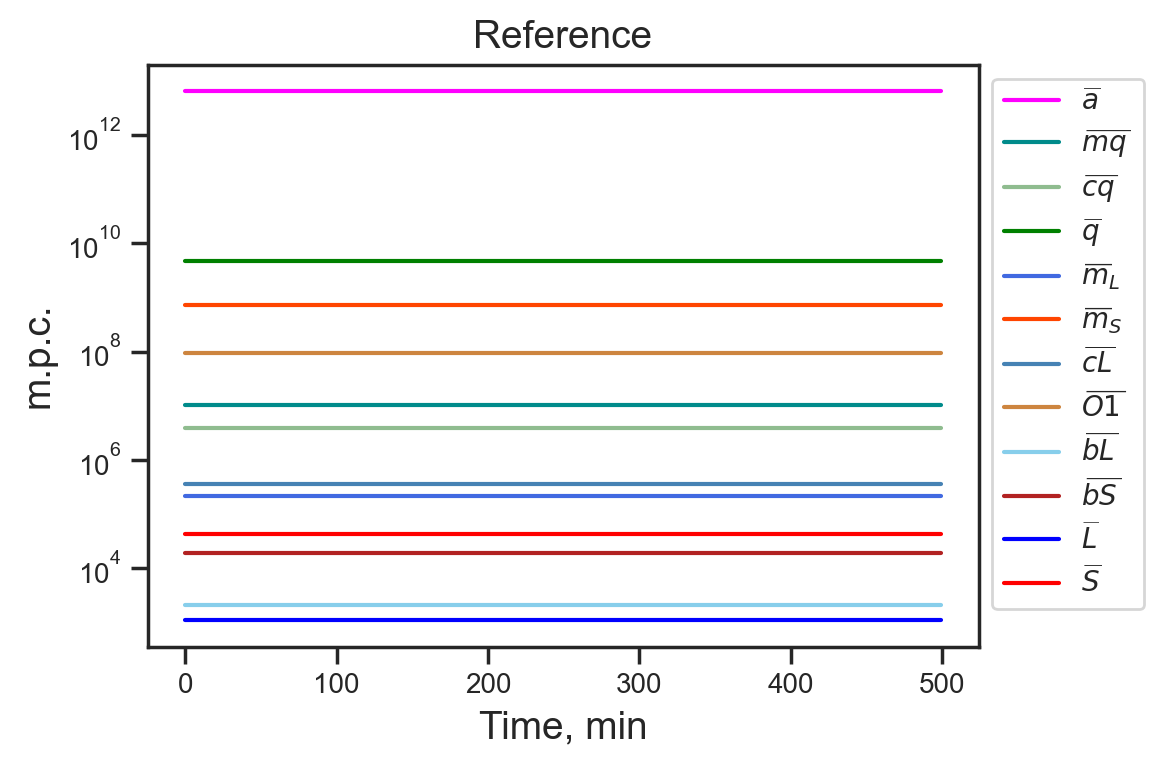

In [222]:
# Time
t_start = 0.
t_finish = 500.
step = 1.
t_span = np.array([t_start, t_finish])
t = np.arange(t_start,t_finish,step)
n0 = 0
n = 500 #int((t_finish-t_start)/step)

# set initial conditions
incond = root0.x.copy()

# integrate
sol = integrate.solve_ivp(integr_syst, t_span, incond, t_eval=t, dense_output=True, method = 'Radau')

# Plot solution
fig, ax = plt.subplots()

ax.plot(sol.t[n0:n], sol.y[0,n0:n], '-', lw=1.5, color=colormap[0], label=r"$\widebar{a}$")
ax.plot(sol.t[n0:n], sol.y[1,n0:n], '-', lw=1.5, color=colormap[1], label=r"$\widebar{mq}$")
ax.plot(sol.t[n0:n], sol.y[2,n0:n], '-', lw=1.5, color=colormap[2], label=r"$\widebar{cq}$")
ax.plot(sol.t[n0:n], sol.y[3,n0:n], '-', lw=1.5, color=colormap[3], label=r"$\widebar{q}$")
ax.plot(sol.t[n0:n], sol.y[4,n0:n], '-', lw=1.5, color=colormap[4], label=r"$\widebar{m}_L$")
ax.plot(sol.t[n0:n], sol.y[5,n0:n], '-', lw=1.5, color=colormap[5], label=r"$\widebar{m}_S$")
ax.plot(sol.t[n0:n], sol.y[6,n0:n], '-', lw=1.5, color=colormap[6], label=r"$\widebar{cL}$")
ax.plot(sol.t[n0:n], sol.y[7,n0:n], '-', lw=1.5, color=colormap[7], label=r"$\widebar{O1}$")
ax.plot(sol.t[n0:n], sol.y[8,n0:n], '-', lw=1.5, color=colormap[8], label=r"$\widebar{bL}$")
ax.plot(sol.t[n0:n], sol.y[9,n0:n], '-', lw=1.5, color=colormap[9], label=r"$\widebar{bS}$")
ax.plot(sol.t[n0:n], sol.y[10,n0:n],'-', lw=1.5, color=colormap[10], label=r"$\widebar{L}$")
ax.plot(sol.t[n0:n], sol.y[11,n0:n],'-', lw=1.5, color=colormap[11], label=r"$\widebar{S}$")

# Set axes
ax.set_title('Reference')
ax.set_xlabel('Time, min')
ax.set_ylabel('m.p.c.')
ax.set_yscale('log')
ax.axis('auto')
ax.legend(bbox_to_anchor=[1.,1])
plt.tight_layout()
plt.show()

## Stochastic simulations

In [223]:
# Specify parameters for calculation
n_generations = 10
n_simulations = 10

# Time
t_start = 0.
t_finish = tdiv*n_generations
step = 1.
time_points = np.arange(t_start,t_finish,step)
n0 = 0
n = int((t_finish-t_start)/step)

# Set initial conditions
population_0 = root0.x.copy().astype(np.int64)

In [156]:
# # write pops
# write2pickle(pops, dir_save+f"pops_gen{n_generations}_sim{n_simulations}.pkl")

# read pops
# pops = read_pickle(dir_save+f"pops_gen{n_generations}_sim{n_simulations}.pkl")
# pops = read_pickle(dir_save+f"pops_gen{n_generations}_sim{n_simulations}_lmdL{lmd_L:.3f}".replace('.','')+".pkl")
# pops = read_pickle(dir_save+f"pops_gen{n_generations}_sim{n_simulations}_lmdL{lmd_L:.3f}_lmdS{lmd_S:.3f}".replace('.','')+".pkl")

In [224]:
# Seed random number generator for reproducibility
seed = 12345
np.random.seed(seed)

# Initialize output array
pops = []
pop = np.empty((len(time_points), 12))

for i in tqdm(range(n_simulations)):
    pop = gillespie_ssa_numba(simple_update, population_0, time_points, tau_leaping=True)
    pops.append(pop)
    # save
    dir_save_tmp = dir_save+'pop/'
    check_dir_exist(dir_save_tmp)
    write2pickle(pop, dir_save_tmp+f"pop_gen{n_generations}_sim{i}.pkl")

# to numpy
pops = np.array(pops)

# write pops
# write2pickle(pops, dir_save+f"pops_gen{n_generations}_sim{n_simulations}.pkl")
# write2pickle(pops, dir_save+f"pops_gen{n_generations}_sim{n_simulations}_lmdL{lmd_L:.3f}".replace('.','')+".pkl")
write2pickle(pops, dir_save+f"pops_gen{n_generations}_sim{n_simulations}_lmdL{lmd_L:.3f}_lmdS{lmd_S:.3f}".replace('.','')+".pkl")

 10%|███████▉                                                                       | 1/10 [57:22<8:36:24, 3442.67s/it]

Done writing list into a binary file


 20%|███████████████▍                                                             | 2/10 [1:55:49<7:44:01, 3480.22s/it]

Done writing list into a binary file


 30%|███████████████████████                                                      | 3/10 [2:55:06<6:50:07, 3515.31s/it]

Done writing list into a binary file


 40%|██████████████████████████████▊                                              | 4/10 [3:54:15<5:52:51, 3528.52s/it]

Done writing list into a binary file


 50%|██████████████████████████████████████▌                                      | 5/10 [4:53:31<4:54:53, 3538.72s/it]

Done writing list into a binary file


 60%|██████████████████████████████████████████████▏                              | 6/10 [5:52:19<3:55:39, 3534.86s/it]

Done writing list into a binary file


 70%|█████████████████████████████████████████████████████▉                       | 7/10 [6:51:16<2:56:47, 3535.72s/it]

Done writing list into a binary file


 80%|█████████████████████████████████████████████████████████████▌               | 8/10 [7:49:51<1:57:38, 3529.21s/it]

Done writing list into a binary file


 90%|███████████████████████████████████████████████████████████████████████        | 9/10 [8:48:24<58:43, 3523.99s/it]

Done writing list into a binary file


100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [9:46:47<00:00, 3520.72s/it]

Done writing list into a binary file
Done writing list into a binary file


# Save pictures

In [158]:
# Set dirtectories
dir_pic_tmp = dir_pic+"ref/" # reference
# dir_pic_tmp = dir_pic+f"lmdL{lmd_L:.3f}/".replace('.','') # lmd_L/2
# dir_pic_tmp = dir_pic+f"lmdL{lmd_L:.3f}_lmdS{lmd_S:.3f}/".replace('.','') # lmd_L/2 & lmd_S/2

# chech directories exit, create if not
check_dir_exist(dir_pic_tmp)
check_dir_exist(dir_pic_tmp+"svg/")

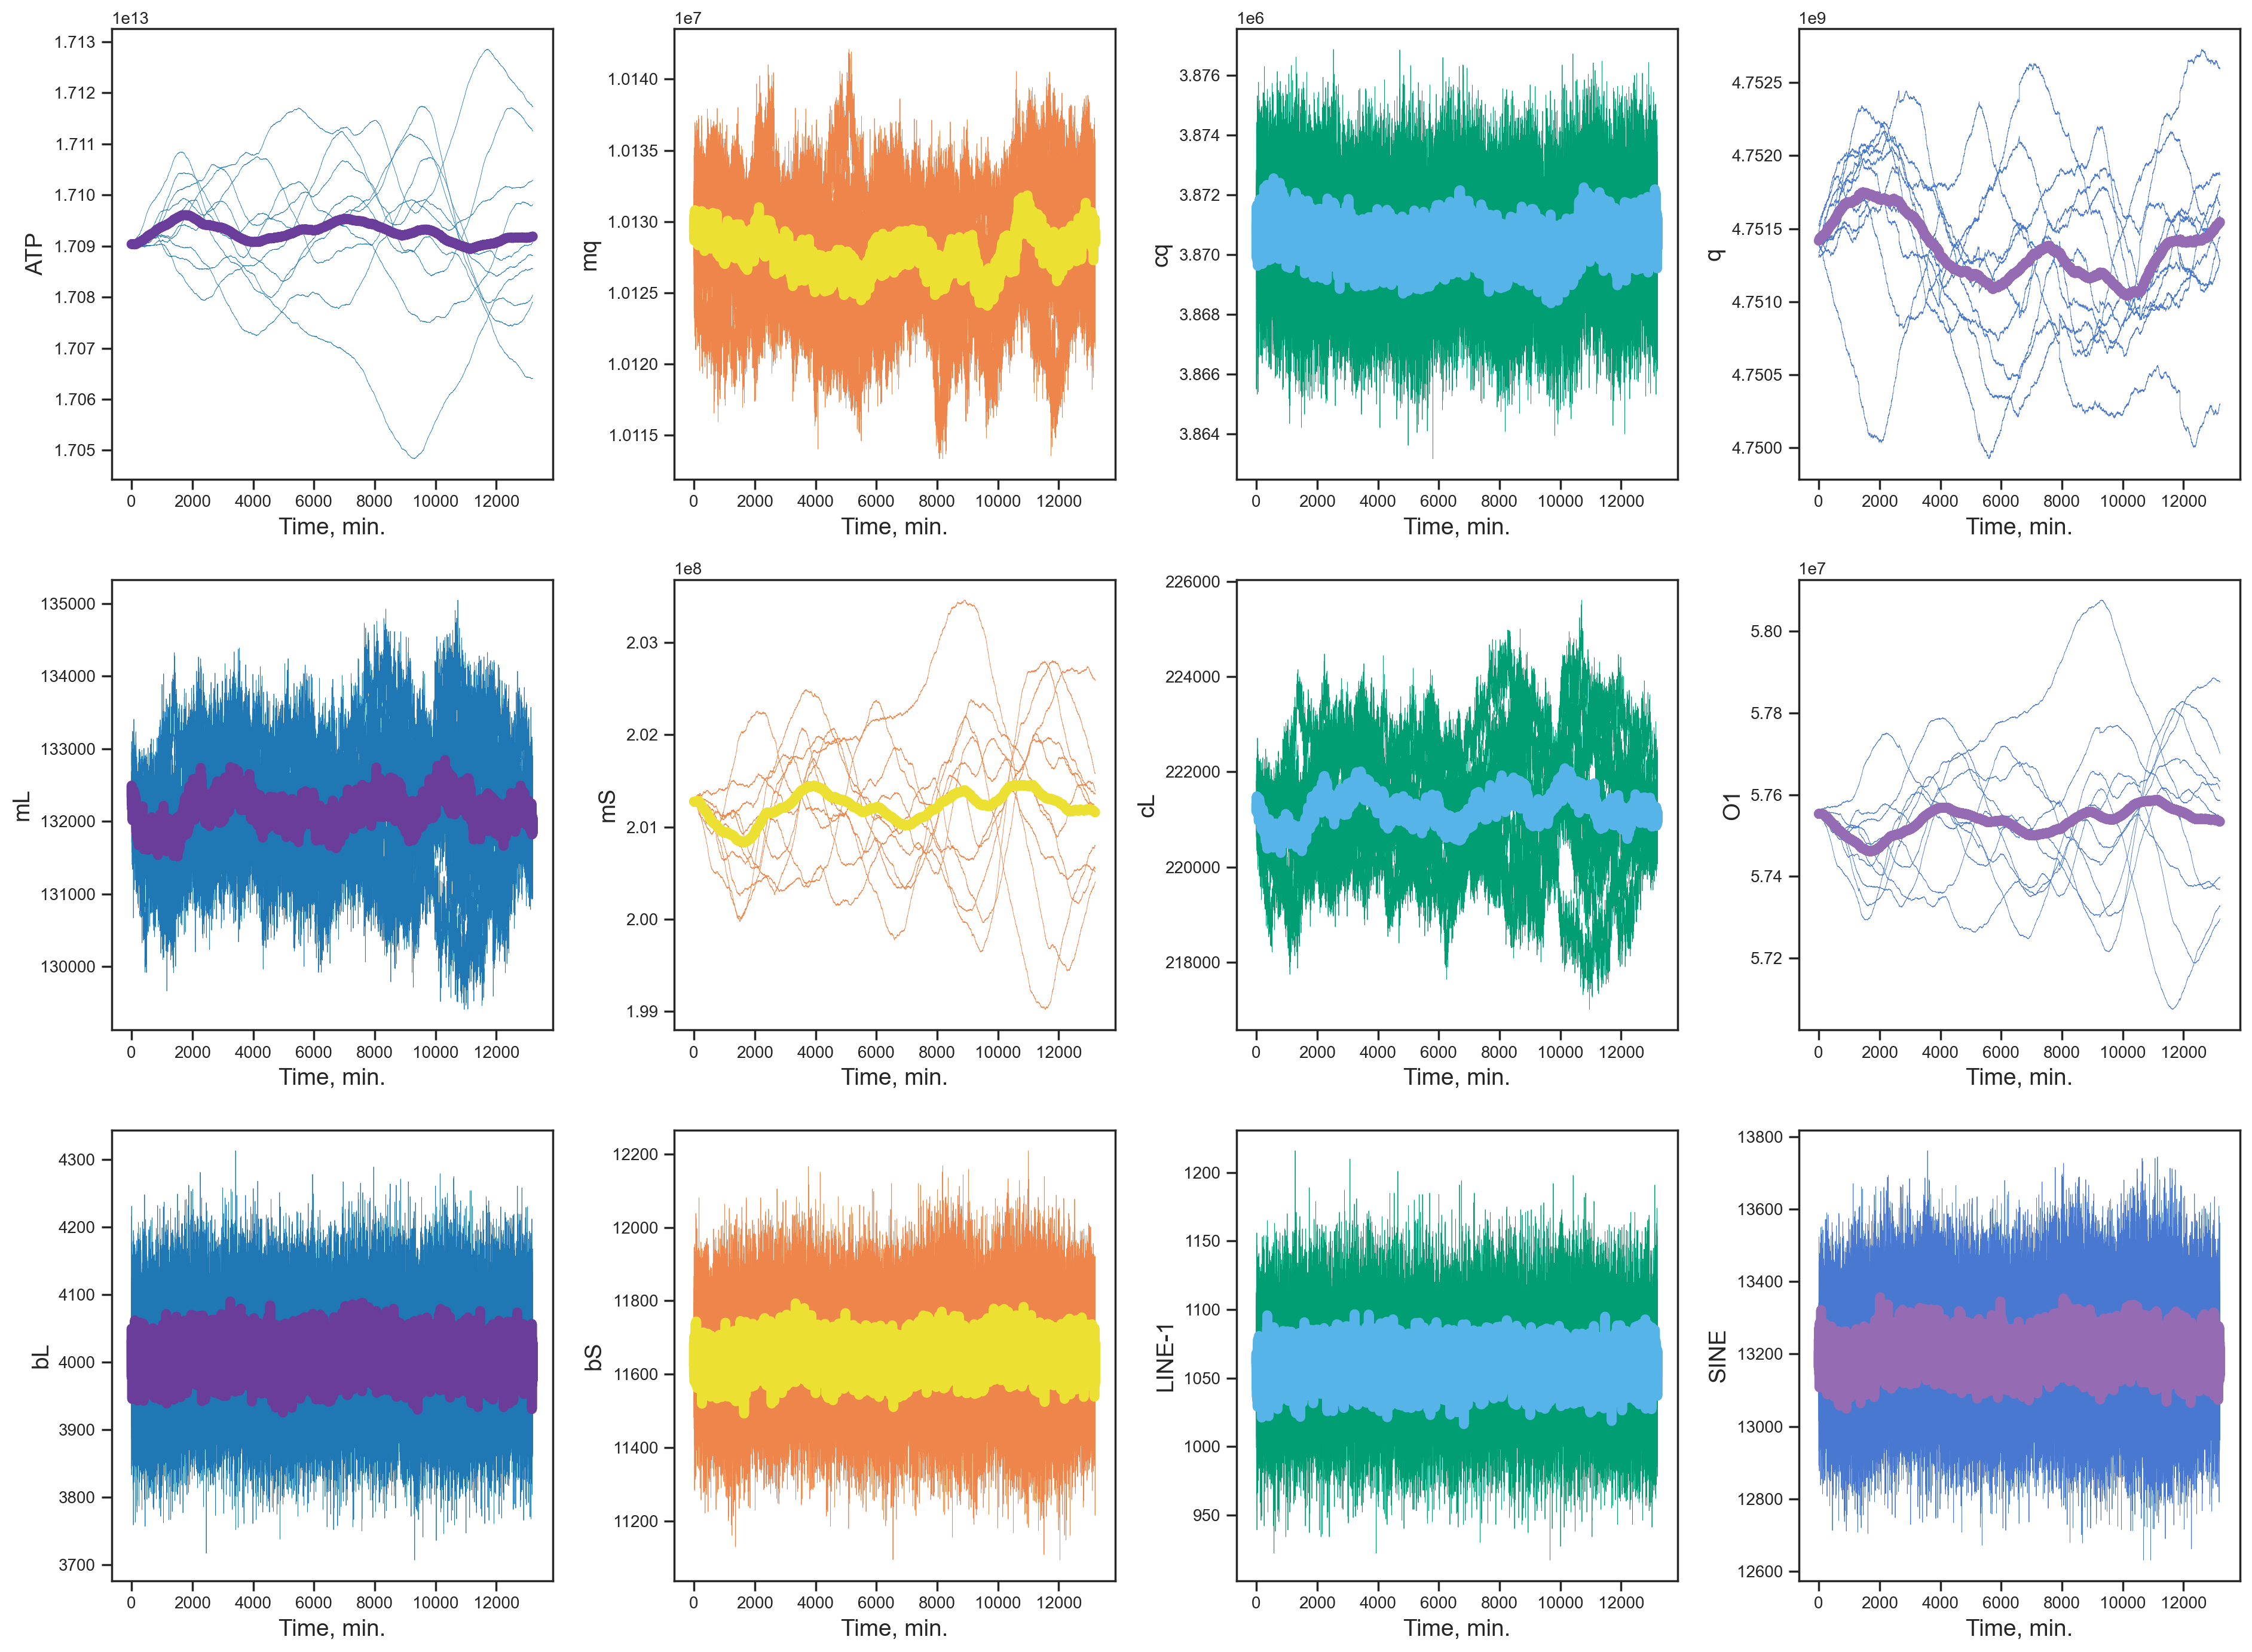

In [159]:
### Colorful ###
fig, axs = plt.subplots(3,4, figsize=(19, 14))
n0 = 0
n = int((t_finish-t_start)/step)

# loop
for j in range(12):
    # Plot trajectories
    ax = axs[j//4,j%4]
    for i in range(n_simulations):
        ax.plot(time_points[0:n], pops[i,0:n,j], '-', lw=0.3, alpha=1, color=colormap1[j%4])
    ax.plot(time_points[0:n], pops[:,0:n,j].mean(axis=0), '-', lw=6, color=colormap2[j%4])
    # Set x-axis
    ax.set_xlabel('Time, min.', fontsize=14)

# Set y-axis
axs[0,0].set_ylabel(   'ATP', fontsize=14)
axs[0,1].set_ylabel(    'mq', fontsize=14)
axs[0,2].set_ylabel(    'cq', fontsize=14)
axs[0,3].set_ylabel(     'q', fontsize=14)
axs[1,0].set_ylabel(    'mL', fontsize=14)
axs[1,1].set_ylabel(    'mS', fontsize=14)
axs[1,2].set_ylabel(    'cL', fontsize=14)
axs[1,3].set_ylabel(    'O1', fontsize=14)
axs[2,0].set_ylabel(    'bL', fontsize=14)
axs[2,1].set_ylabel(    'bS', fontsize=14)
axs[2,2].set_ylabel('LINE-1', fontsize=14)
axs[2,3].set_ylabel(  'SINE', fontsize=14)
plt.tight_layout()

# save figure
fig_name = f"pops_gen{n_generations}_sim{n_simulations}_dyn"
plt.savefig(dir_pic_tmp+f"{fig_name}.png", bbox_inches='tight')
plt.savefig(dir_pic_tmp+f"svg/{fig_name}.svg", bbox_inches='tight')
plt.show()

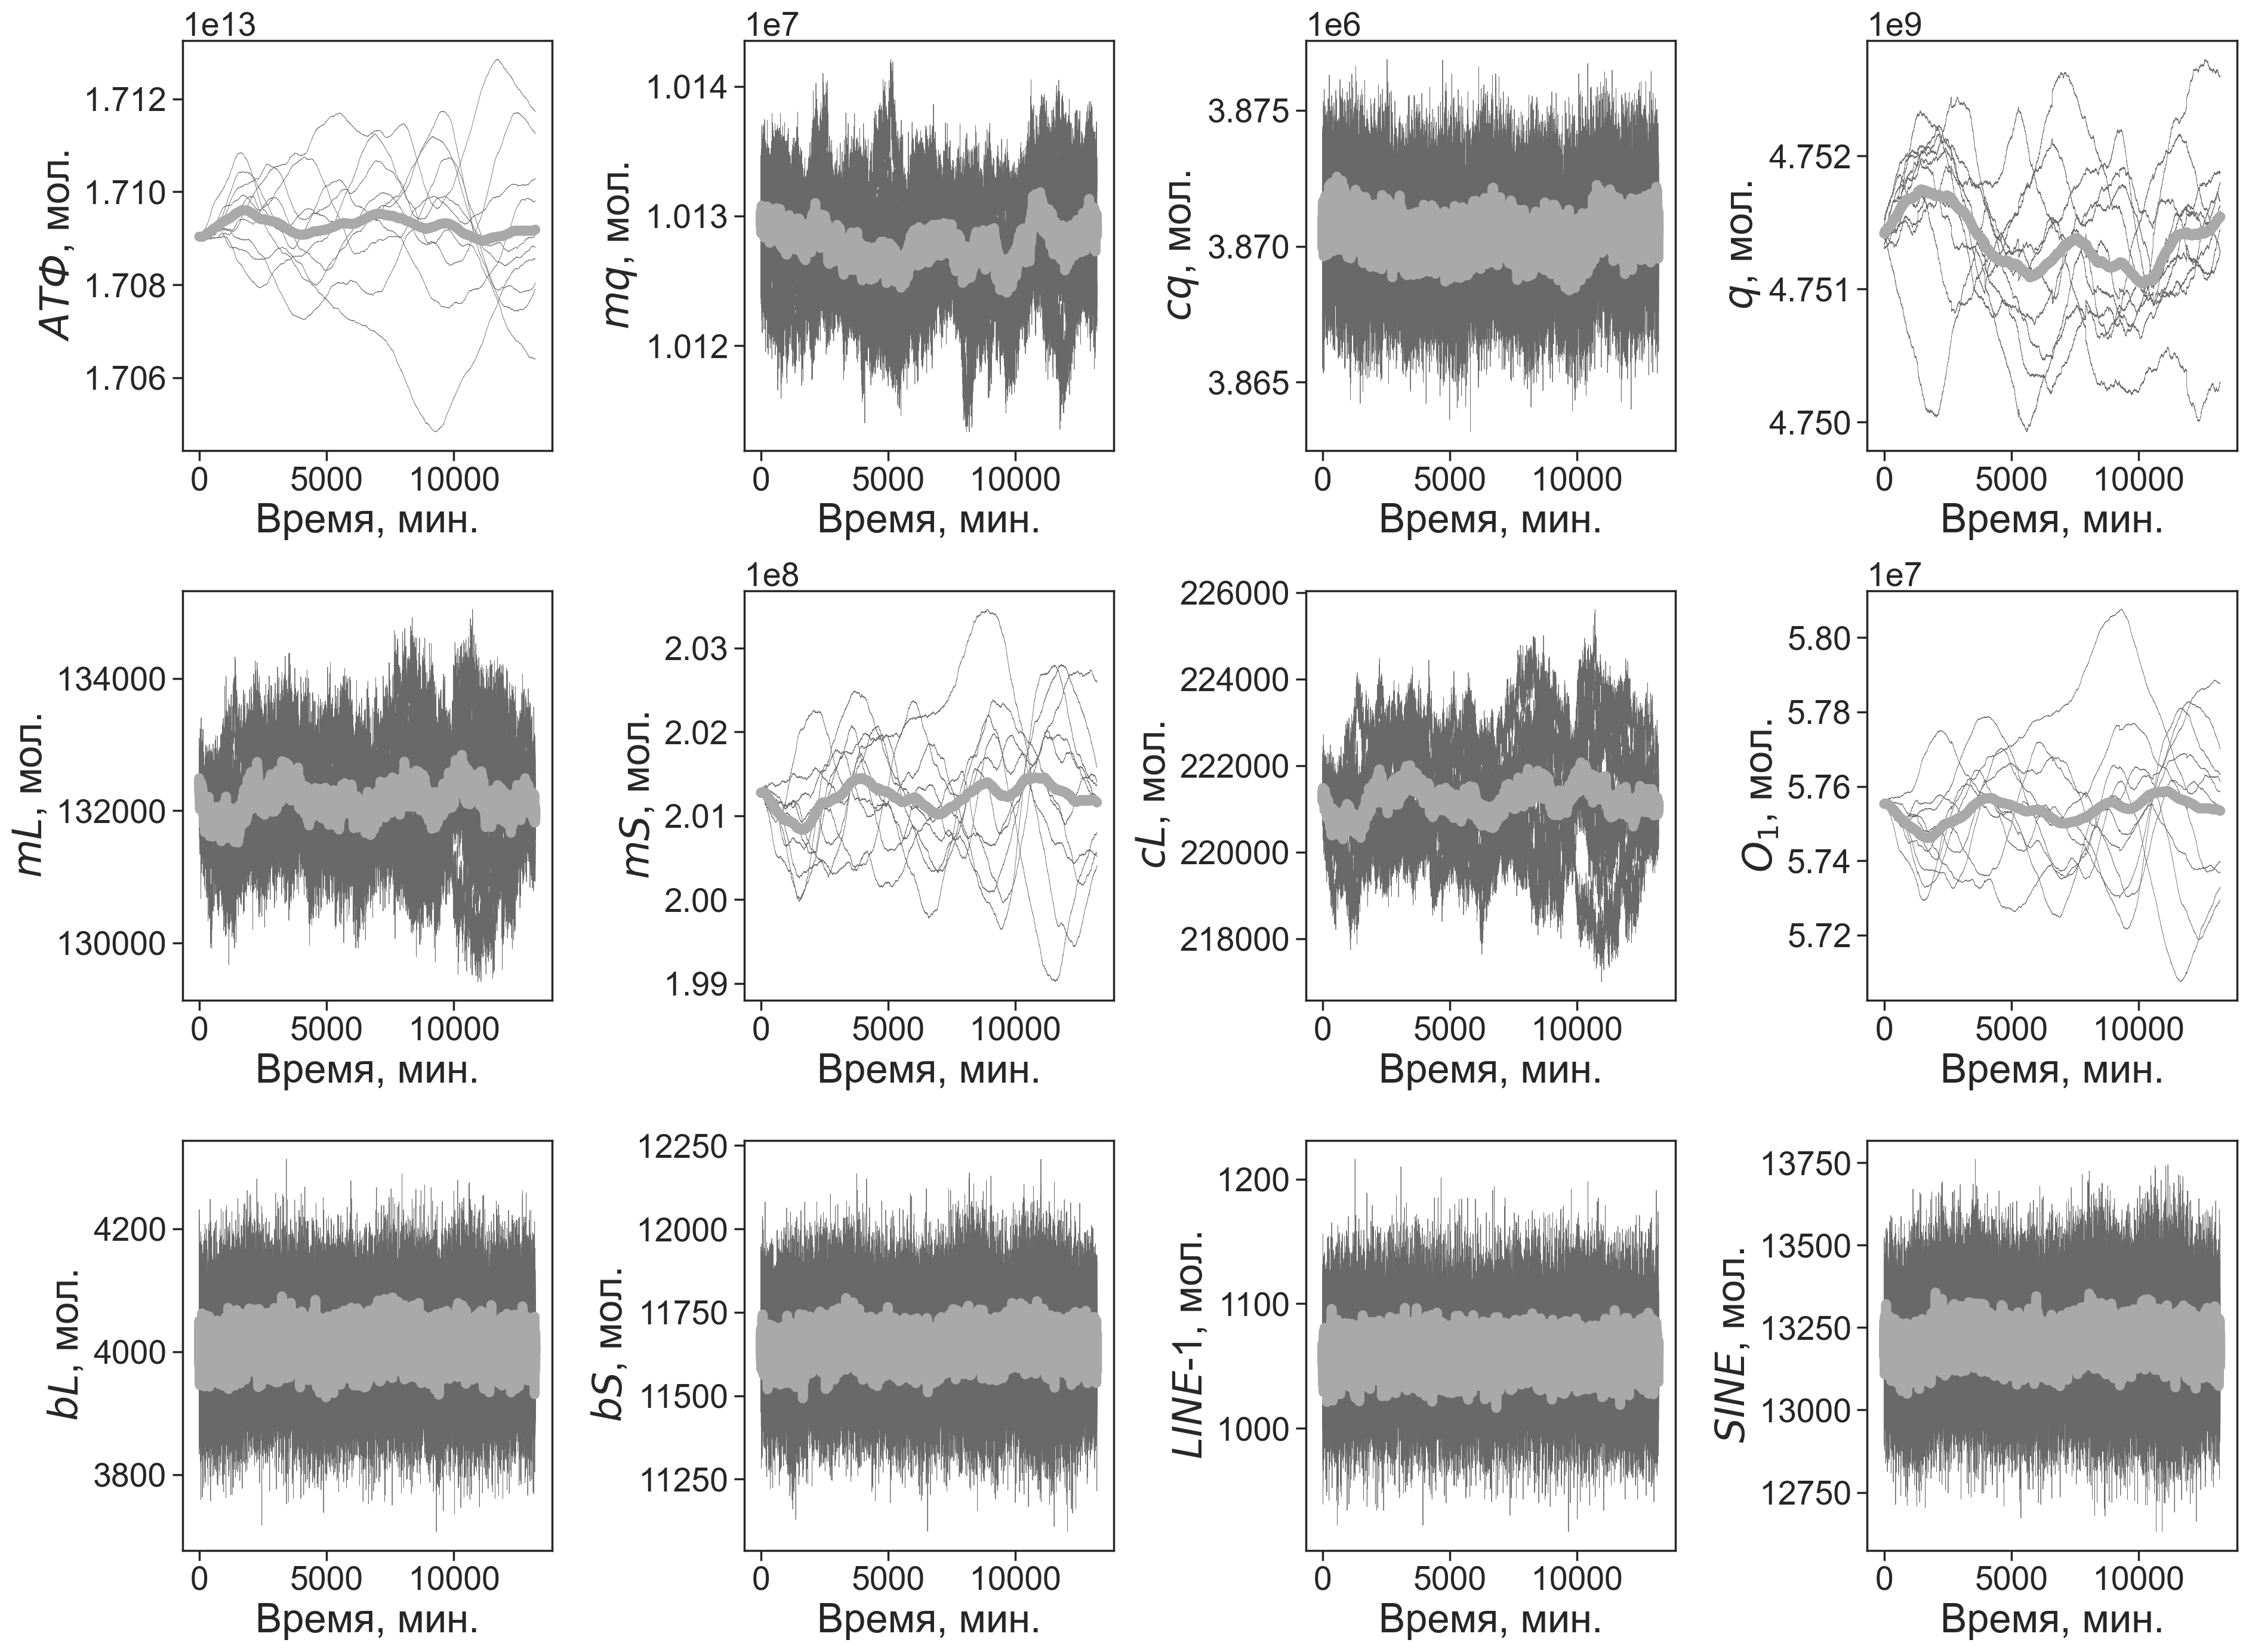

In [160]:
### Balck & White ###
fig, axs = plt.subplots(3,4, figsize=(19, 14))
n0 = 0
n = int((t_finish-t_start)/step)

# loop
for j in range(12):
    # Plot trajectories
    ax = axs[j//4,j%4]
    for i in range(n_simulations):
        ax.plot(time_points[0:n:1], pops[i,0:n:1,j], '-', lw=0.3, alpha=1, color='dimgrey')
    ax.plot(    time_points[0:n:1], pops[:,0:n:1,j].mean(axis=0), '-', lw=6, color='darkgrey')
    # Set x-axis
    ax.set_xlabel('Время, мин.', fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ext = ax.yaxis.get_offset_text()
    ext.set_size(20)

# Set y-axis
axs[0,0].set_ylabel(   '$АТФ$, мол.', fontsize=24)
axs[0,1].set_ylabel(    '$mq$, мол.', fontsize=24)
axs[0,2].set_ylabel(    '$cq$, мол.', fontsize=24)
axs[0,3].set_ylabel(     '$q$, мол.', fontsize=24)
axs[1,0].set_ylabel(    '$mL$, мол.', fontsize=24)
axs[1,1].set_ylabel(    '$mS$, мол.', fontsize=24)
axs[1,2].set_ylabel(    '$cL$, мол.', fontsize=24)
axs[1,3].set_ylabel(   '$O_1$, мол.', fontsize=24)
axs[2,0].set_ylabel(    '$bL$, мол.', fontsize=24)
axs[2,1].set_ylabel(    '$bS$, мол.', fontsize=24)
axs[2,2].set_ylabel('$LINE$-1, мол.', fontsize=24)
axs[2,3].set_ylabel(  '$SINE$, мол.', fontsize=24)
fig.set_tight_layout(True)

# save figure
fig_name = f"pops_gen{n_generations}_sim{n_simulations}_dyn_bw"
fig.savefig(dir_pic_tmp+f"{fig_name}.png", bbox_inches='tight')
fig.savefig(dir_pic_tmp+f"svg/{fig_name}.svg", bbox_inches='tight')
plt.show()

# Statistics

In [250]:
# Calculate statistics (mean, standard deviation, coefficient of variation)
mean = np.zeros(12)
std = np.zeros(12)
for i in range(12):
    mean[i] = pops[:,:,i].mean()
    std[i] = pops[:,:,i].std()

var = ['a','mq','cq','q','mL','mS','cL','O1','bL','bS','L','S']
div_mean_root = (abs(sty0 - mean) / sty0) * 100 # %
CV = std/mean * 100 # %

# to DataFrame
df = pd.DataFrame(data=np.vstack((mean,std,div_mean_root,CV)).T, 
                  columns=['mean','std','div_mean_root','CV'])
df

mean           std  div_mean_root        CV
0   1.709266e+13  1.251497e+10       0.013417  0.073218
1   1.012777e+07  3.832720e+03       0.003910  0.037844
2   3.870422e+06  1.616358e+03       0.001485  0.041762
3   4.751356e+09  5.426730e+05       0.001868  0.011421
4   1.321511e+05  7.656996e+02       0.039670  0.579412
5   2.012156e+08  7.249147e+05       0.030838  0.360268
6   2.212129e+05  1.191339e+03       0.034770  0.538549
7   5.753423e+07  1.570299e+05       0.032199  0.272933
8   4.007184e+03  6.876275e+01       0.009938  1.715987
9   1.164733e+04  1.253756e+02       0.033805  1.076432
10  1.058233e+03  3.292106e+01       0.034483  3.110947
11  1.320287e+04  1.340919e+02       0.038120  1.015627

## Stats on 1 generation

In [162]:
# extract pops on 1 generation
pops_1gen = []
for i in range(pops.shape[0]):
    k = 0
    for j in range(pops.shape[1]//int(tdiv)):
        pops_1gen.append(pops[i,j*int(tdiv):(j+1)*int(tdiv),:])

# to numpy
pops_1gen = np.array(pops_1gen)

In [163]:
# Calculate sigma by time
std_t = np.zeros([pops_1gen.shape[1],12])
mean_t = np.zeros([pops_1gen.shape[1],12])
for i in range(pops_1gen.shape[2]):
    for j in range(pops_1gen.shape[1]):
        std_t[j,i] = pops_1gen[:,j,i].std()
        mean_t[j,i] = pops_1gen[:,j,i].mean()
#
CV_t = std_t/mean_t * 100 # %

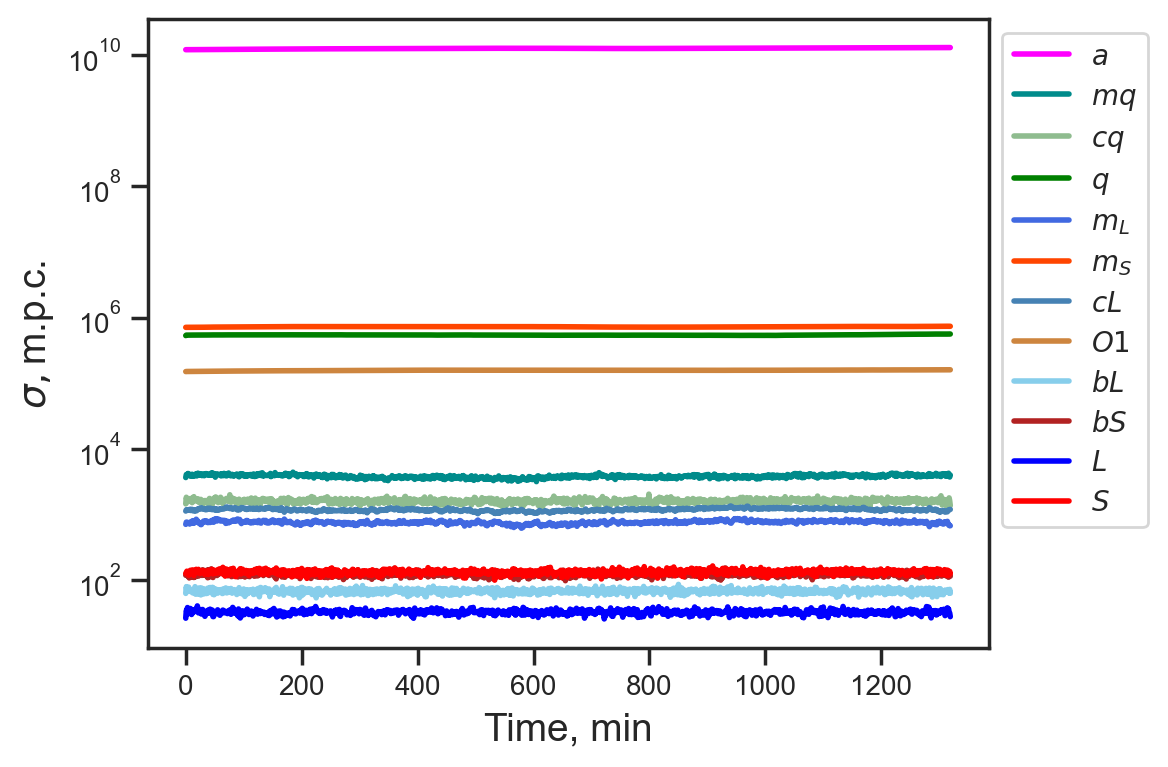

In [164]:
# Plot standard deviations by molecules
fig, ax = plt.subplots()

# Time
t_start = 0.
t_finish = tdiv
tps = np.arange(t_start,t_finish,step)

# Plot
ax.plot(tps, std_t[:,0], '-', lw=2, color=colormap[0],  label=r"$a$")
ax.plot(tps, std_t[:,1], '-', lw=2, color=colormap[1],  label=r"$mq$")
ax.plot(tps, std_t[:,2], '-', lw=2, color=colormap[2],  label=r"$cq$")
ax.plot(tps, std_t[:,3], '-', lw=2, color=colormap[3],  label=r"$q$")
ax.plot(tps, std_t[:,4], '-', lw=2, color=colormap[4],  label=r"$m_L$")
ax.plot(tps, std_t[:,5], '-', lw=2, color=colormap[5],  label=r"$m_S$")
ax.plot(tps, std_t[:,6], '-', lw=2, color=colormap[6],  label=r"$cL$")
ax.plot(tps, std_t[:,7], '-', lw=2, color=colormap[7],  label=r"$O1$")
ax.plot(tps, std_t[:,8], '-', lw=2, color=colormap[8],  label=r"$bL$")
ax.plot(tps, std_t[:,9], '-', lw=2, color=colormap[9],  label=r"$bS$")
ax.plot(tps, std_t[:,10],'-', lw=2, color=colormap[10], label=r"$L$")
ax.plot(tps, std_t[:,11],'-', lw=2, color=colormap[11], label=r"$S$")
        
# Set axes
ax.set_xlabel('Time, min')
ax.set_ylabel(r'$\sigma,$m.p.c.')
ax.set_yscale('log')
ax.axis('auto')
ax.legend(bbox_to_anchor=[1.,1])
fig.set_tight_layout(True)

# save figure
fig_name = f"pops_gen{n_generations}_sim{n_simulations}_sigma_by_time"
fig.savefig(dir_pic_tmp+f"{fig_name}.png", bbox_inches='tight')
fig.savefig(dir_pic_tmp+f"svg/{fig_name}.svg", bbox_inches='tight')
plt.show()

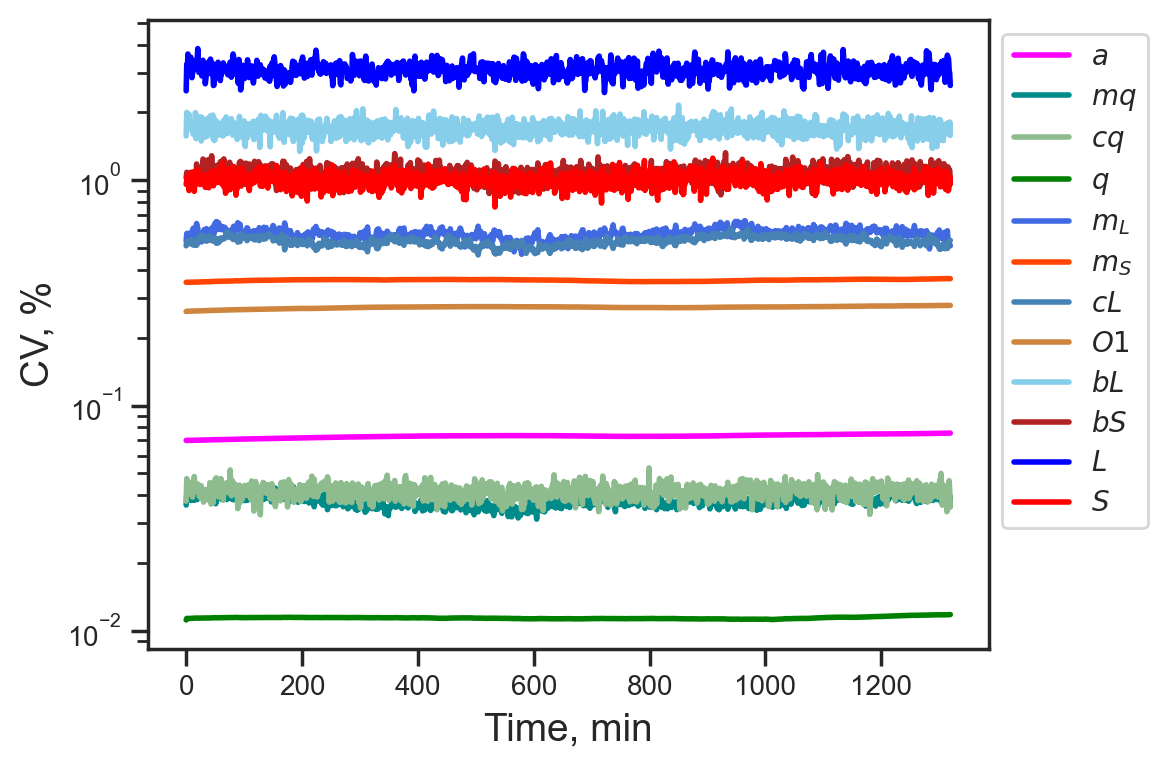

In [165]:
# Plot standard deviations by molecules
fig, ax = plt.subplots()

# Time
t_start = 0.
t_finish = tdiv
tps = np.arange(t_start,t_finish,step)

# Plot
ax.plot(tps, CV_t[:,0], '-', lw=2, color=colormap[0],  label=r"$a$")
ax.plot(tps, CV_t[:,1], '-', lw=2, color=colormap[1],  label=r"$mq$")
ax.plot(tps, CV_t[:,2], '-', lw=2, color=colormap[2],  label=r"$cq$")
ax.plot(tps, CV_t[:,3], '-', lw=2, color=colormap[3],  label=r"$q$")
ax.plot(tps, CV_t[:,4], '-', lw=2, color=colormap[4],  label=r"$m_L$")
ax.plot(tps, CV_t[:,5], '-', lw=2, color=colormap[5],  label=r"$m_S$")
ax.plot(tps, CV_t[:,6], '-', lw=2, color=colormap[6],  label=r"$cL$")
ax.plot(tps, CV_t[:,7], '-', lw=2, color=colormap[7],  label=r"$O1$")
ax.plot(tps, CV_t[:,8], '-', lw=2, color=colormap[8],  label=r"$bL$")
ax.plot(tps, CV_t[:,9], '-', lw=2, color=colormap[9],  label=r"$bS$")
ax.plot(tps, CV_t[:,10],'-', lw=2, color=colormap[10], label=r"$L$")
ax.plot(tps, CV_t[:,11],'-', lw=2, color=colormap[11], label=r"$S$")
        
# Set axes
ax.set_xlabel('Time, min')
ax.set_ylabel('CV, %')
ax.set_yscale('log')
ax.axis('auto')
ax.legend(bbox_to_anchor=[1.,1])
fig.set_tight_layout(True)

# save figure
fig_name = f"pops_gen{n_generations}_sim{n_simulations}_CV_by_time"
fig.savefig(dir_pic_tmp+f"{fig_name}.png", bbox_inches='tight')
fig.savefig(dir_pic_tmp+f"svg/{fig_name}.svg", bbox_inches='tight')
plt.show()

## Total statistics

In [166]:
# Get total ditribution (by cells from different generations)
p_num = int(tdiv*n_generations*n_simulations)
pops_tot = np.concatenate((pops[:,:,:]),axis=0)

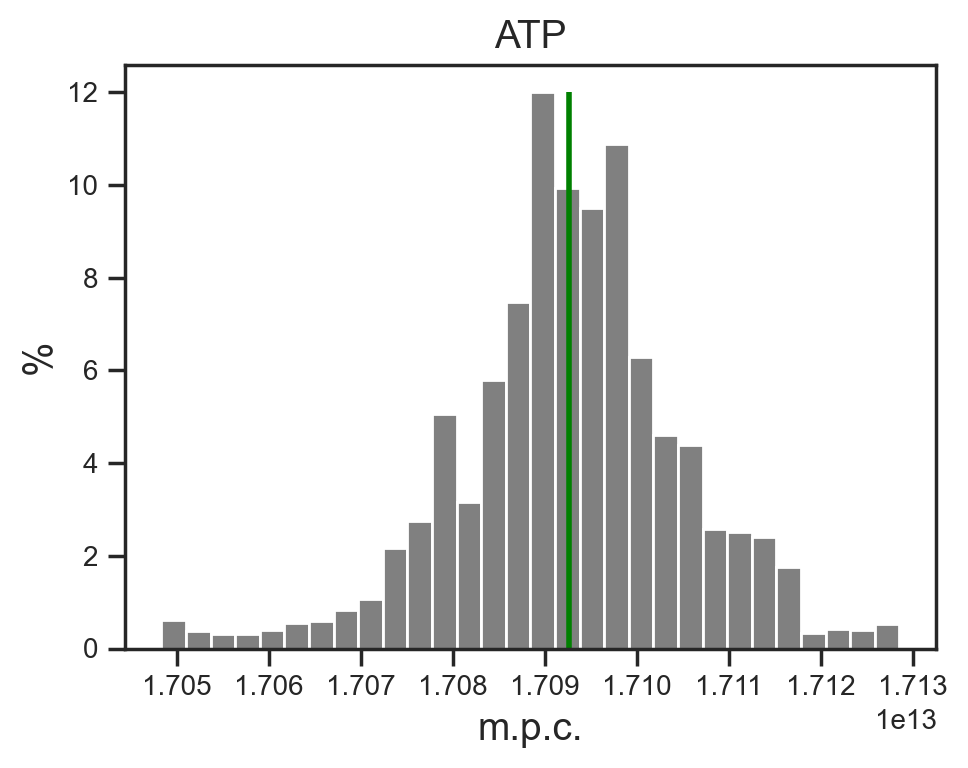

In [167]:
# Plot distribution of the number of ATP molecules in a cell (by time and by cells)
i=0
n_bins = 30
weights = np.repeat(100/p_num,p_num)

# PLot
fig,ax = plt.subplots(figsize=(5,4))
hist = ax.hist(pops_tot[::,i], density=False, bins=n_bins, weights=weights[::], color='gray')
ax.vlines(x=mean[i], ymin=0, ymax=hist[0].max(), lw=2, color='green')
ax.set_title("ATP")
ax.set_ylabel('%')
ax.set_xlabel('m.p.c.')
ax.tick_params(axis='both')
fig.set_tight_layout(True)

# save figure
fig_name = f"pops_gen{n_generations}_sim{n_simulations}_a_hist"
fig.savefig(dir_pic_tmp+f"{fig_name}.png", bbox_inches='tight')
fig.savefig(dir_pic_tmp+f"svg/{fig_name}.svg", bbox_inches='tight')
plt.show()

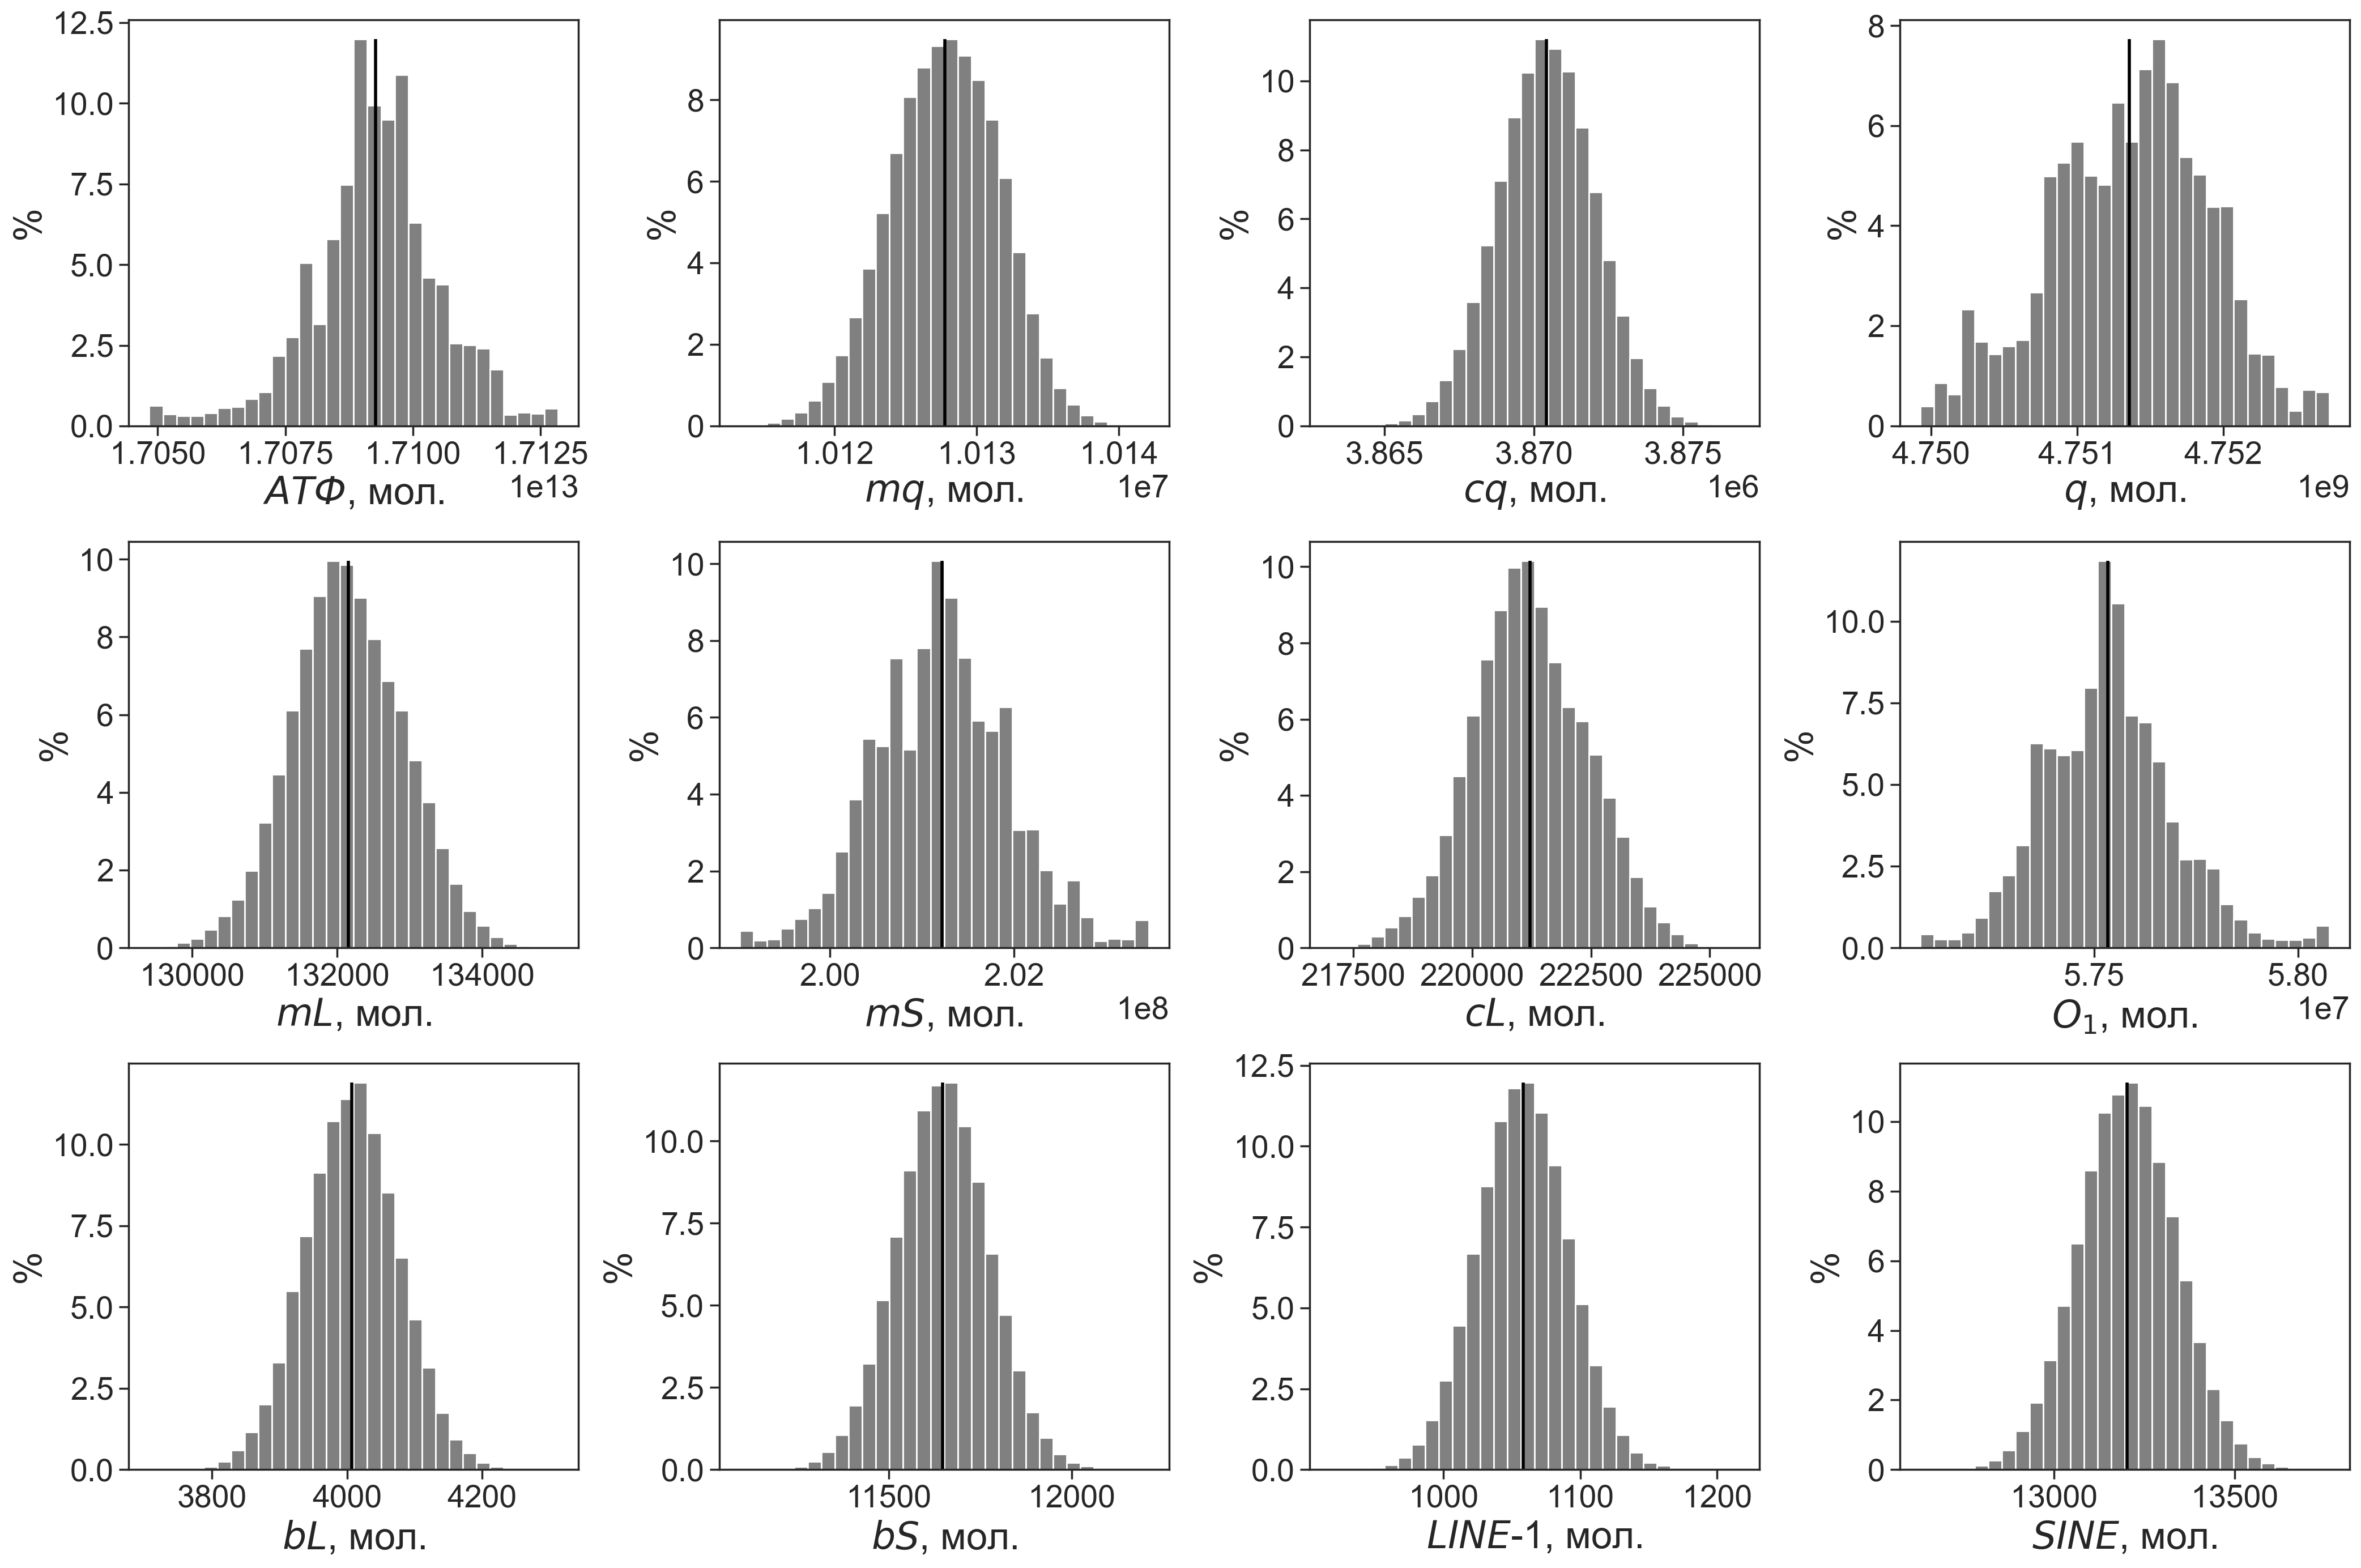

In [168]:
# Plot distribution of the number of molecules (by cells and by time)
n_bins = 30
weights = np.repeat(100/p_num,p_num)

# Plot
fig, axs = plt.subplots(3,4, figsize=(21,14))
for i in range(12):
    # Plot distributions
    ax = axs[i//4,i%4]
    hist = ax.hist(pops_tot[::,i], density=False, bins=n_bins, weights=weights[::], color='gray')
    ax.vlines(x=mean[i], ymin=0, ymax=hist[0].max(), lw=2, color='black') # color=green or black
    # Set y-axis
    ax.set_ylabel('%', fontsize=24)
    ax.tick_params(axis='both', labelsize=20)
    ext = ax.xaxis.get_offset_text()
    ext.set_size(20)

# Set x-axis
axs[0,0].set_xlabel(     '$АТФ$, мол.', fontsize=24)
axs[0,1].set_xlabel(      '$mq$, мол.', fontsize=24)
axs[0,2].set_xlabel(      '$cq$, мол.', fontsize=24)
axs[0,3].set_xlabel(       '$q$, мол.', fontsize=24)
axs[1,0].set_xlabel(      '$mL$, мол.', fontsize=24)
axs[1,1].set_xlabel(      '$mS$, мол.', fontsize=24)
axs[1,2].set_xlabel(      '$cL$, мол.', fontsize=24)
axs[1,3].set_xlabel(     '$O_1$, мол.', fontsize=24)
axs[2,0].set_xlabel(      '$bL$, мол.', fontsize=24)
axs[2,1].set_xlabel(      '$bS$, мол.', fontsize=24)
axs[2,2].set_xlabel(  '$LINE$-1, мол.', fontsize=24)
axs[2,3].set_xlabel(    '$SINE$, мол.', fontsize=24)
fig.set_tight_layout(True)

# save figure
fig_name = f"pops_gen{n_generations}_sim{n_simulations}_hist_bw"
fig.savefig(dir_pic_tmp+f"{fig_name}.png", bbox_inches='tight')
fig.savefig(dir_pic_tmp+f"svg/{fig_name}.svg", bbox_inches='tight')
plt.show()

## Check normality of data

### Check normality of ATP distribution over cells

In [169]:
# Shapiro-Wilk Test
from scipy.stats import shapiro
# normality test
stat, p = shapiro(pops_tot[:,0])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret results
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.982, p=0.000
Sample does not look Gaussian (reject H0)


D:\All\Python\myenv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [170]:
# D'Agostino and Pearson's Test
from scipy.stats import normaltest
# normality test
stat, p = normaltest(pops_tot[:,0])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret results
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=5579.274, p=0.000
Sample does not look Gaussian (reject H0)


In [171]:
# Anderson-Darling Test
from scipy.stats import anderson
# normality test
result = anderson(pops_tot[:,0])
print('Statistic: %.3f' % result.statistic)
p = 0
# interpret results
for i in range(len(result.critical_values)):
    slevel, cvalues = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (slevel, cvalues))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (slevel, cvalues))

Statistic: 606.709
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)


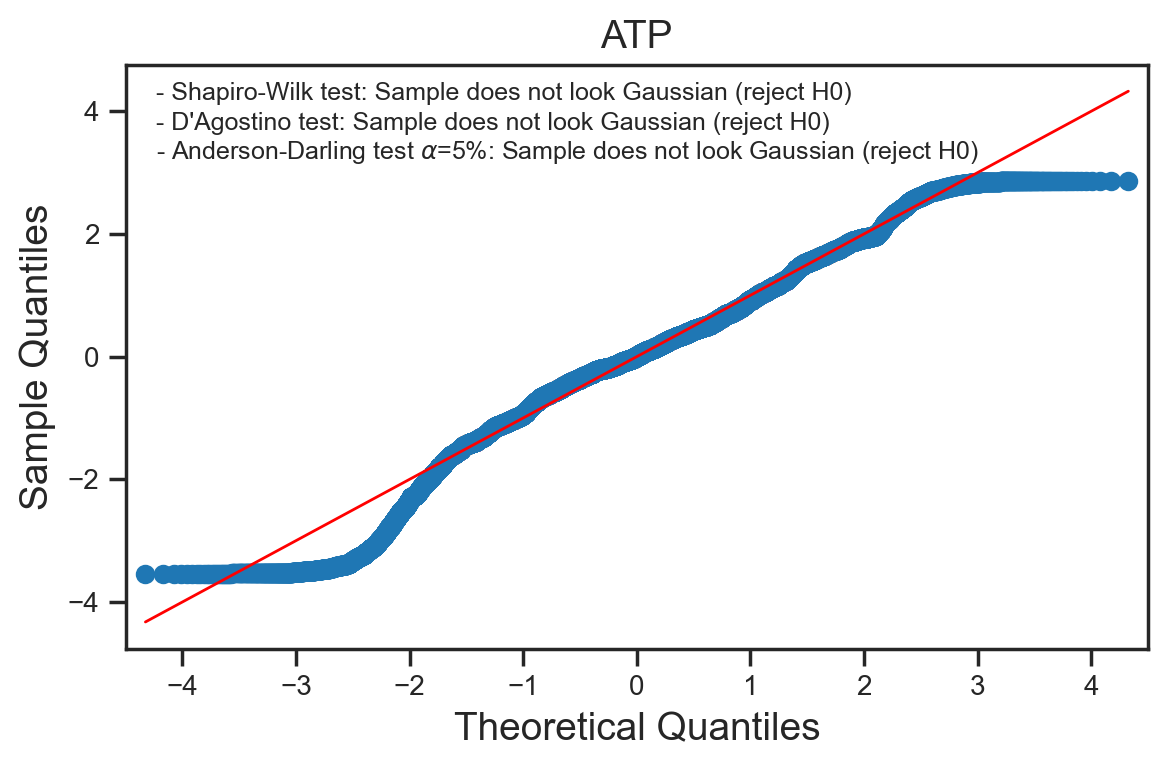

In [172]:
# q-q plot (ATP)
i = 0 # ATP
txt_size = 9
fig, ax = plt.subplots()
qqplot(pops_tot[:,i], line='s',ax=ax, fit=True)

# Shapiro-Wilk test
stat, p = shapiro(pops_tot[:,i])
# interpret results
alpha = 0.05
if p > alpha:
    ax.text(0.03, 0.95, "- Shapiro-Wilk test: Sample looks Gaussian (fail to reject H0)", verticalalignment='center', transform=ax.transAxes, size=txt_size)
else:
    ax.text(0.03, 0.95, "- Shapiro-Wilk test: Sample does not look Gaussian (reject H0)", verticalalignment='center', transform=ax.transAxes, size=txt_size)

# D'Agostino and Pearson's Test
stat, p = normaltest(pops_tot[:,i])
# interpret results
alpha = 0.05
if p > alpha:
    ax.text(0.03, 0.9, "- D'Agostino test: Sample looks Gaussian (fail to reject H0)", verticalalignment='center', transform=ax.transAxes, size=txt_size)
else:
    ax.text(0.03, 0.9, "- D'Agostino test: Sample does not look Gaussian (reject H0)", verticalalignment='center', transform=ax.transAxes, size=txt_size)

# Anderson-Darling Test
result = anderson(pops_tot[:,i])
# interpret results
k = 2
if result.statistic < result.critical_values[k]:
    ax.text(0.03, 0.85, r"- Anderson-Darling test $\alpha$=5%: Sample looks Gaussian (fail to reject H0)", verticalalignment='center', transform=ax.transAxes, size=txt_size)
else:
    ax.text(0.03, 0.85, r"- Anderson-Darling test $\alpha$=5%: Sample does not look Gaussian (reject H0)", verticalalignment='center', transform=ax.transAxes, size=txt_size)

# Set axes
ax.set_title("ATP")
fig.set_tight_layout(True)
plt.show()

### Check normality of molecules distribution over cells

In [253]:
### Calculate tests p-values ###
data_bool = []
data_pval = []
istep = 100

# loop by molecules
for i in range(12):
    # Initialize
    dat_b = []
    dat_p = []
    
    # Shapiro-Wilk test
    stat, p = shapiro(pops_tot[::istep,i])
    dat_p.append(p)
    # interpret results
    alpha = 0.05
    if p > alpha:
        dat_b.append(True)
    else:
        dat_b.append(False)
    
    # D'Agostino and Pearson's Test
    stat, p = normaltest(pops_tot[::istep,i])
    dat_p.append(p)
    # interpret results
    alpha = 0.05
    if p > alpha:
        dat_b.append(True)
    else:
        dat_b.append(False)
    
    # Anderson-Darling Test
    result = anderson(pops_tot[::istep,i])
    dat_p.append(result.statistic)
    # interpret results
    k = 2 # alpha == 5%
    if result.statistic < result.critical_values[k]:
        dat_b.append(True)
    else:
        dat_b.append(False)

    # add row to data
    data_bool.append(dat_b)
    data_pval.append(dat_p)

# to DataFrame
print(f"Anderson-Darling critical_value with alpha==5%: {result.critical_values[k]}")
df_bool = pd.DataFrame(data_bool, columns=['shapiro','dagusto','anderson'], index=var)
df_pval = pd.DataFrame(data_pval, columns=['shapiro','dagusto','anderson'], index=var)
print(df_bool, "\n", df_pval)

Anderson-Darling critical_value with alpha==5%: 0.785
    shapiro  dagusto  anderson
a     False    False     False
mq     True     True      True
cq     True     True      True
q     False    False     False
mL     True     True      True
mS    False    False     False
cL     True     True     False
O1    False    False     False
bL     True     True      True
bS     True     True      True
L      True     True      True
S      True     True      True 
          shapiro       dagusto  anderson
a   3.719900e-12  1.397025e-13  6.293584
mq  8.052579e-01  6.564138e-01  0.237161
cq  5.701726e-01  4.500693e-01  0.384495
q   5.193631e-06  1.047711e-03  2.253616
mL  6.723371e-01  4.146273e-01  0.264362
mS  3.238942e-03  3.201320e-02  0.957990
cL  2.046509e-01  3.880563e-01  0.790617
O1  1.415654e-08  4.064153e-09  3.205885
bL  3.983835e-01  1.578980e-01  0.404840
bS  8.464721e-01  7.110799e-01  0.261360
L   1.042563e-01  2.010596e-01  0.298761
S   2.944827e-01  8.045164e-01  0.192956


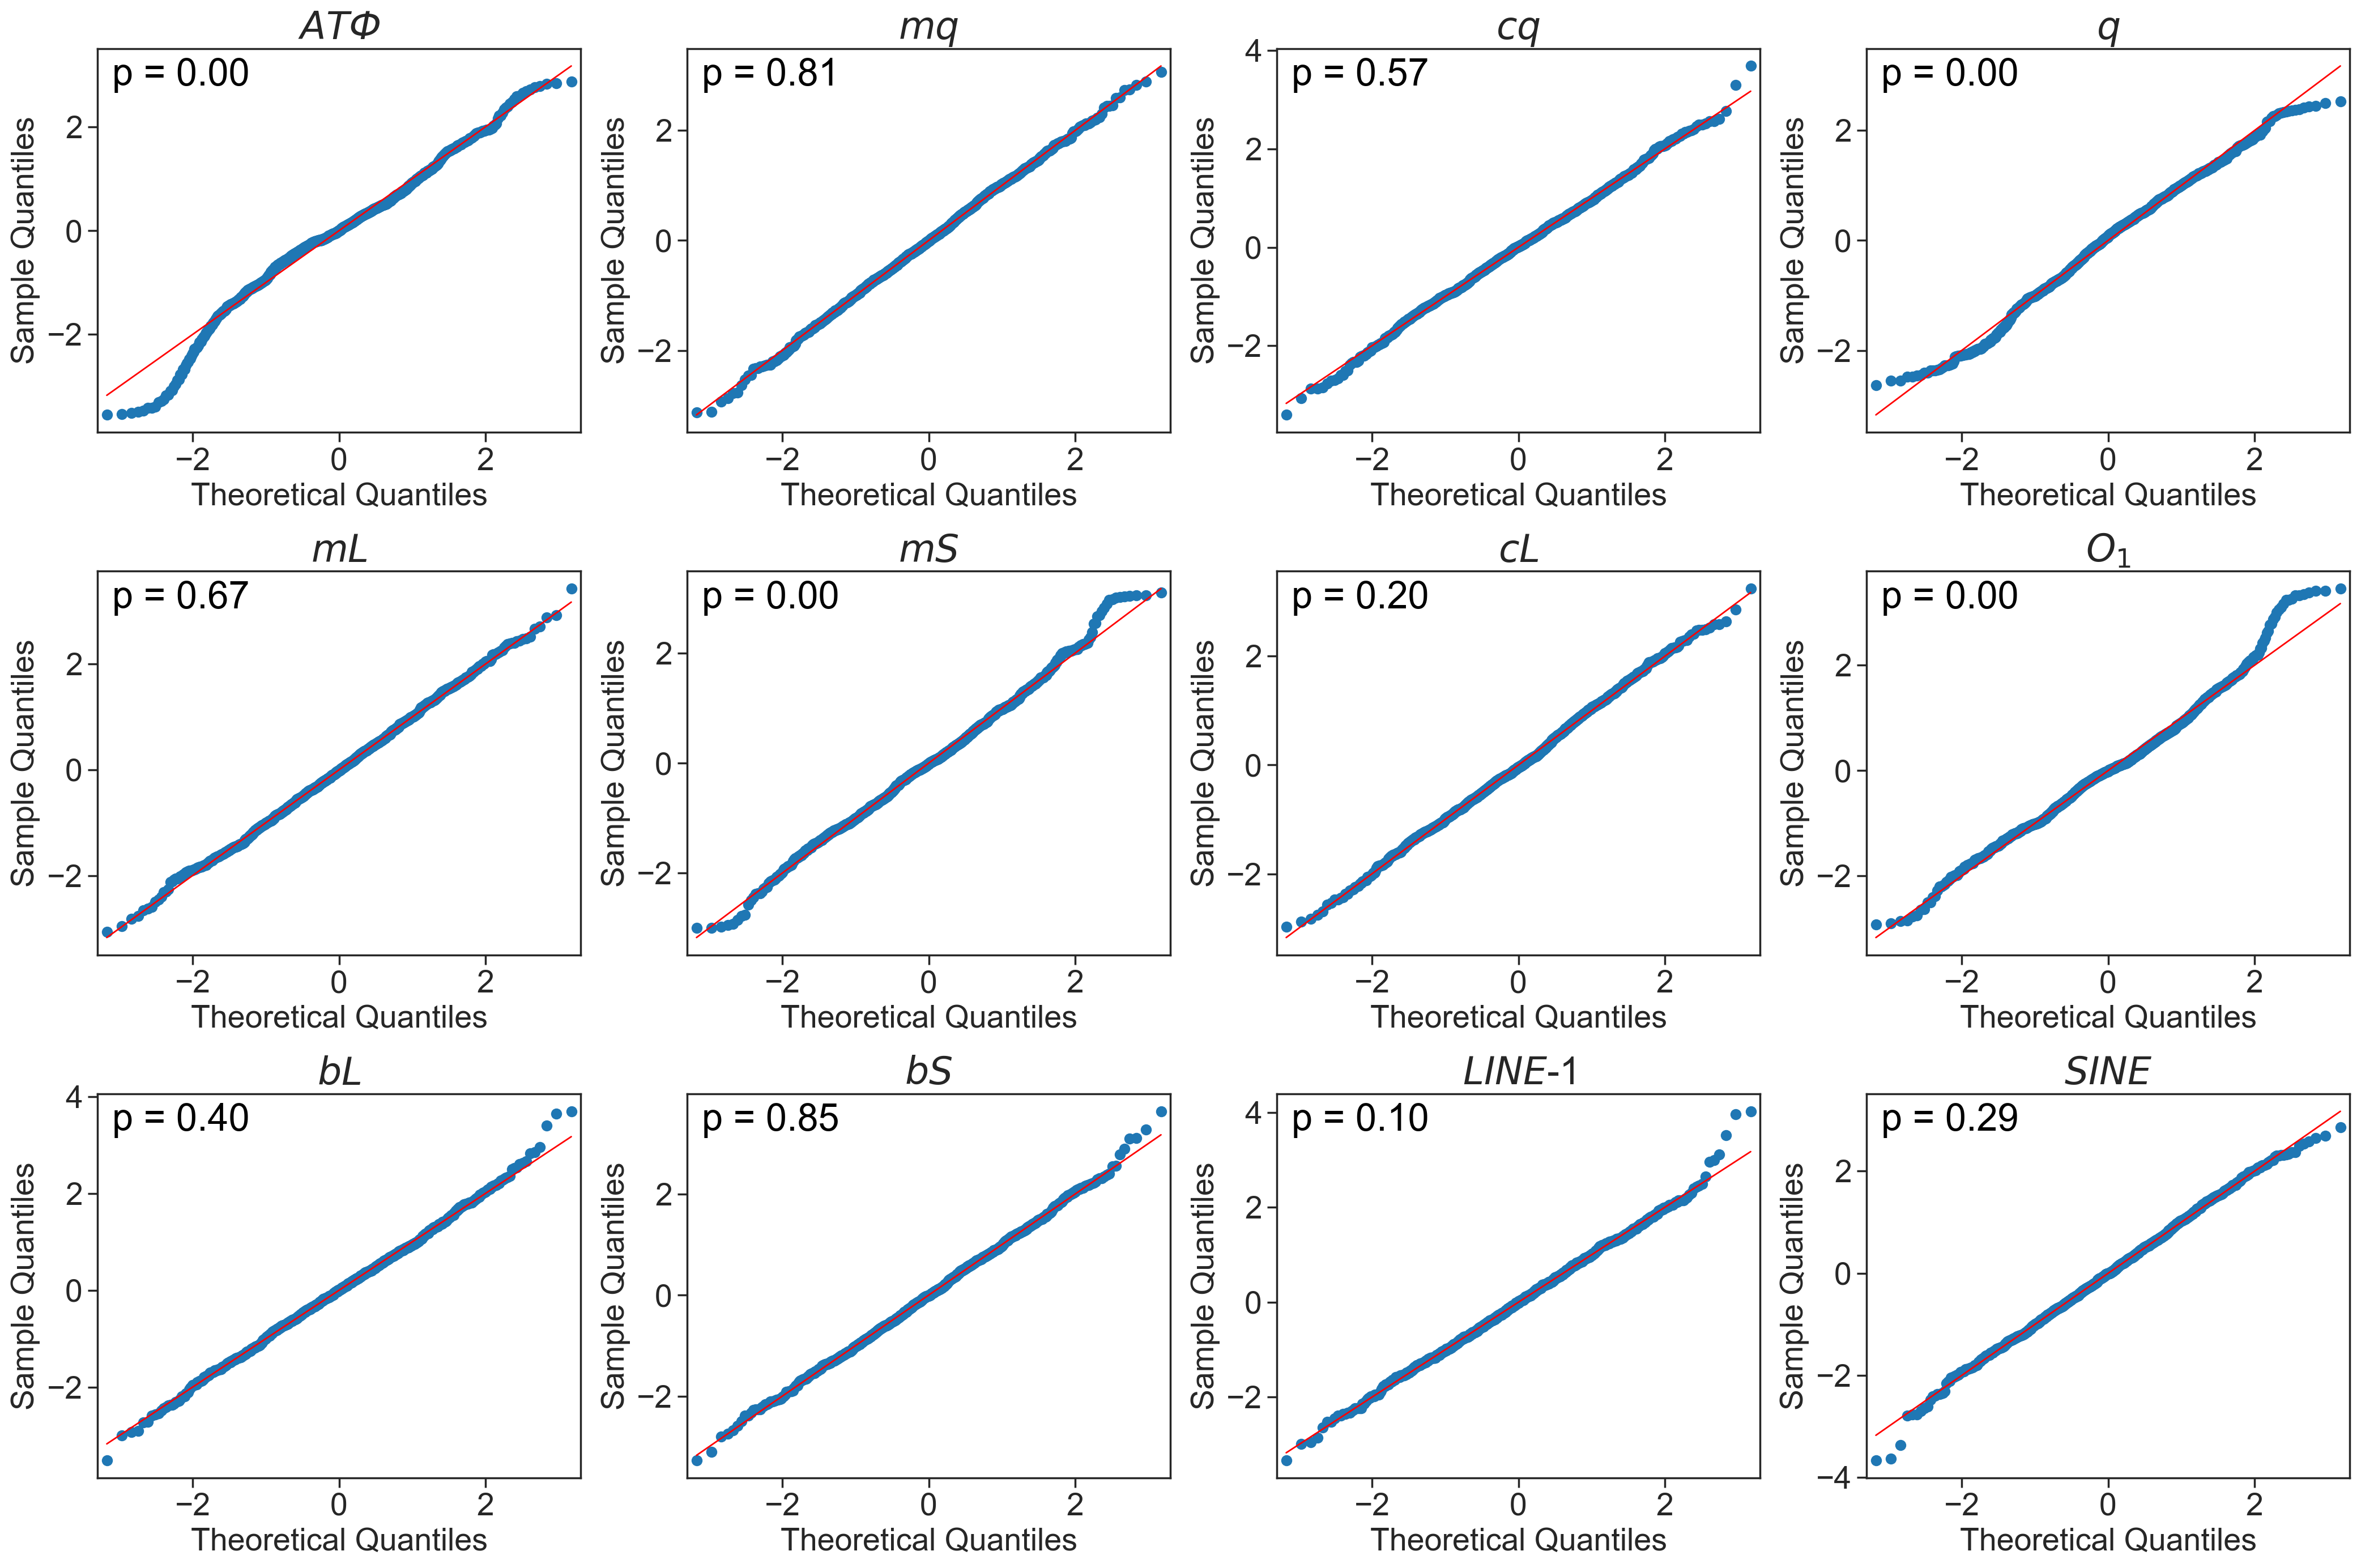

In [254]:
# Plot normal-tests
fig, axs = plt.subplots(3,4, figsize=(21, 14))

### Plot trajectories
i = 0
for idx,s in df_pval.iterrows():
    ax = axs[i//4,i%4]
    qqplot(pops_tot[::istep,i], line='s', ax=ax, fit=True)

    # Text
    ax.text(0.03, 0.93, f"p = {s.loc['shapiro']:.2f}", verticalalignment='center', transform=ax.transAxes, size=24, color='black')
        
    # Set y-axis
    # ax.set_ylabel('')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.tick_params(axis='both', labelsize=20)
    i += 1
    
# Set x-axis
axs[0,0].set_title(   '$АТФ$', fontsize=24)
axs[0,1].set_title(    '$mq$', fontsize=24)
axs[0,2].set_title(    '$cq$', fontsize=24)
axs[0,3].set_title(     '$q$', fontsize=24)
axs[1,0].set_title(    '$mL$', fontsize=24)
axs[1,1].set_title(    '$mS$', fontsize=24)
axs[1,2].set_title(    '$cL$', fontsize=24)
axs[1,3].set_title(   '$O_1$', fontsize=24)
axs[2,0].set_title(    '$bL$', fontsize=24)
axs[2,1].set_title(    '$bS$', fontsize=24)
axs[2,2].set_title('$LINE$-1', fontsize=24)
axs[2,3].set_title(  '$SINE$', fontsize=24)
fig.set_tight_layout(True)

# save figure
fig_name = f"pops_gen{n_generations}_sim{n_simulations}_qqplot"
fig.savefig(dir_pic_tmp+f"{fig_name}.png", bbox_inches='tight')
fig.savefig(dir_pic_tmp+f"svg/{fig_name}.svg", bbox_inches='tight')
plt.show()

# Statistics compare

## Load modified model simulations data and compare

In [232]:
# Some model values
tdiv = 1320  # Cell cycle duration, [min]
n_generations = 10
n_simulations = 10

In [233]:
# read pops
pops = read_pickle(dir_save+f"pops_gen{n_generations}_sim{n_simulations}.pkl")

# read pops
# pops2 = read_pickle(dir_save+f"pops_gen{n_generations}_sim{n_simulations}_lmdL{lmd_L/2:.3f}".replace('.','')+".pkl")
pops2 = read_pickle(dir_save+f"pops_gen{n_generations}_sim{n_simulations}_lmdL{lmd_L/2:.3f}_lmdS{lmd_S/2:.3f}".replace('.','')+".pkl")

In [234]:
# Calculate statistics by cells from all generations
mean = np.zeros(12)
std = np.zeros(12)
for i in range(12):
    mean[i] = pops[:,:,i].mean()
    std[i] = pops[:,:,i].std()

# Calculate statistics by cells from all generations (modified model)
mean2 = np.zeros(12)
std2 = np.zeros(12)
for i in range(12):
    mean2[i] = pops2[:,:,i].mean()
    std2[i] = pops2[:,:,i].std()

In [235]:
# extract pops on 1 generation
pops_1gen = []
for i in range(pops.shape[0]):
    k = 0
    for j in range(pops.shape[1]//int(tdiv)):
        pops_1gen.append(pops[i,j*int(tdiv):(j+1)*int(tdiv),:])

# to numpy
pops_1gen = np.array(pops_1gen)

### Model2 (perturbed) ###
# extract pops on 1 generation
pops2_1gen = []
for i in range(pops2.shape[0]):
    k = 0
    for j in range(pops2.shape[1]//int(tdiv)):
        pops2_1gen.append(pops2[i,j*int(tdiv):(j+1)*int(tdiv),:])

# to numpy
pops2_1gen = np.array(pops2_1gen)

In [236]:
# Get total ditribution (by cells from different generations)
p_num = int(tdiv*n_generations*n_simulations)

# Get pops total ditribution
pops_tot = np.concatenate((pops[:,:,:]),axis=0)

# Get pops total ditribution
pops2_tot = np.concatenate((pops2[:,:,:]),axis=0)

## Energy consumtion

In [237]:
# Check real part of eigenvalues 
def en_cons_rates(y):
    a_,mq_,cq_,q_,mL_,mS_,cL_,O1_,bL_,bS_,L_,S_ = y

    # Rates of energy consumption::
    ecr = [
         # integration
         Nnt* vintL(bL_,O1_,a_)*nL + Nnt* vintS(bS_,a_)*nS,
         # replication
         vreplf(a_,bL_,O1_,bS_),
         # translation
         Naa* vq(cq_,a_)*nq,
         Naa* vL(cL_,a_)*(nL/3),
         # transcription
         Nnt* om_q(a_)*(nQ),
         Nnt* om_S(S_,a_)*nS + Nnt* om_L(L_,a_)*nL]
    
    ecr = np.array(ecr).astype(np.float64)
    return ecr

In [238]:
# Calculate energy consumtion
en_cons = np.zeros([pops_tot.shape[0],6])
for i in range(pops_tot.shape[0]):
    en_cons[i,:] = en_cons_rates(pops_tot[i,:])

# Calculate energy consumtion
en_cons2 = np.zeros([pops2_tot.shape[0],6])
for i in range(pops2_tot.shape[0]):
    en_cons2[i,:] = en_cons_rates(pops2_tot[i,:])

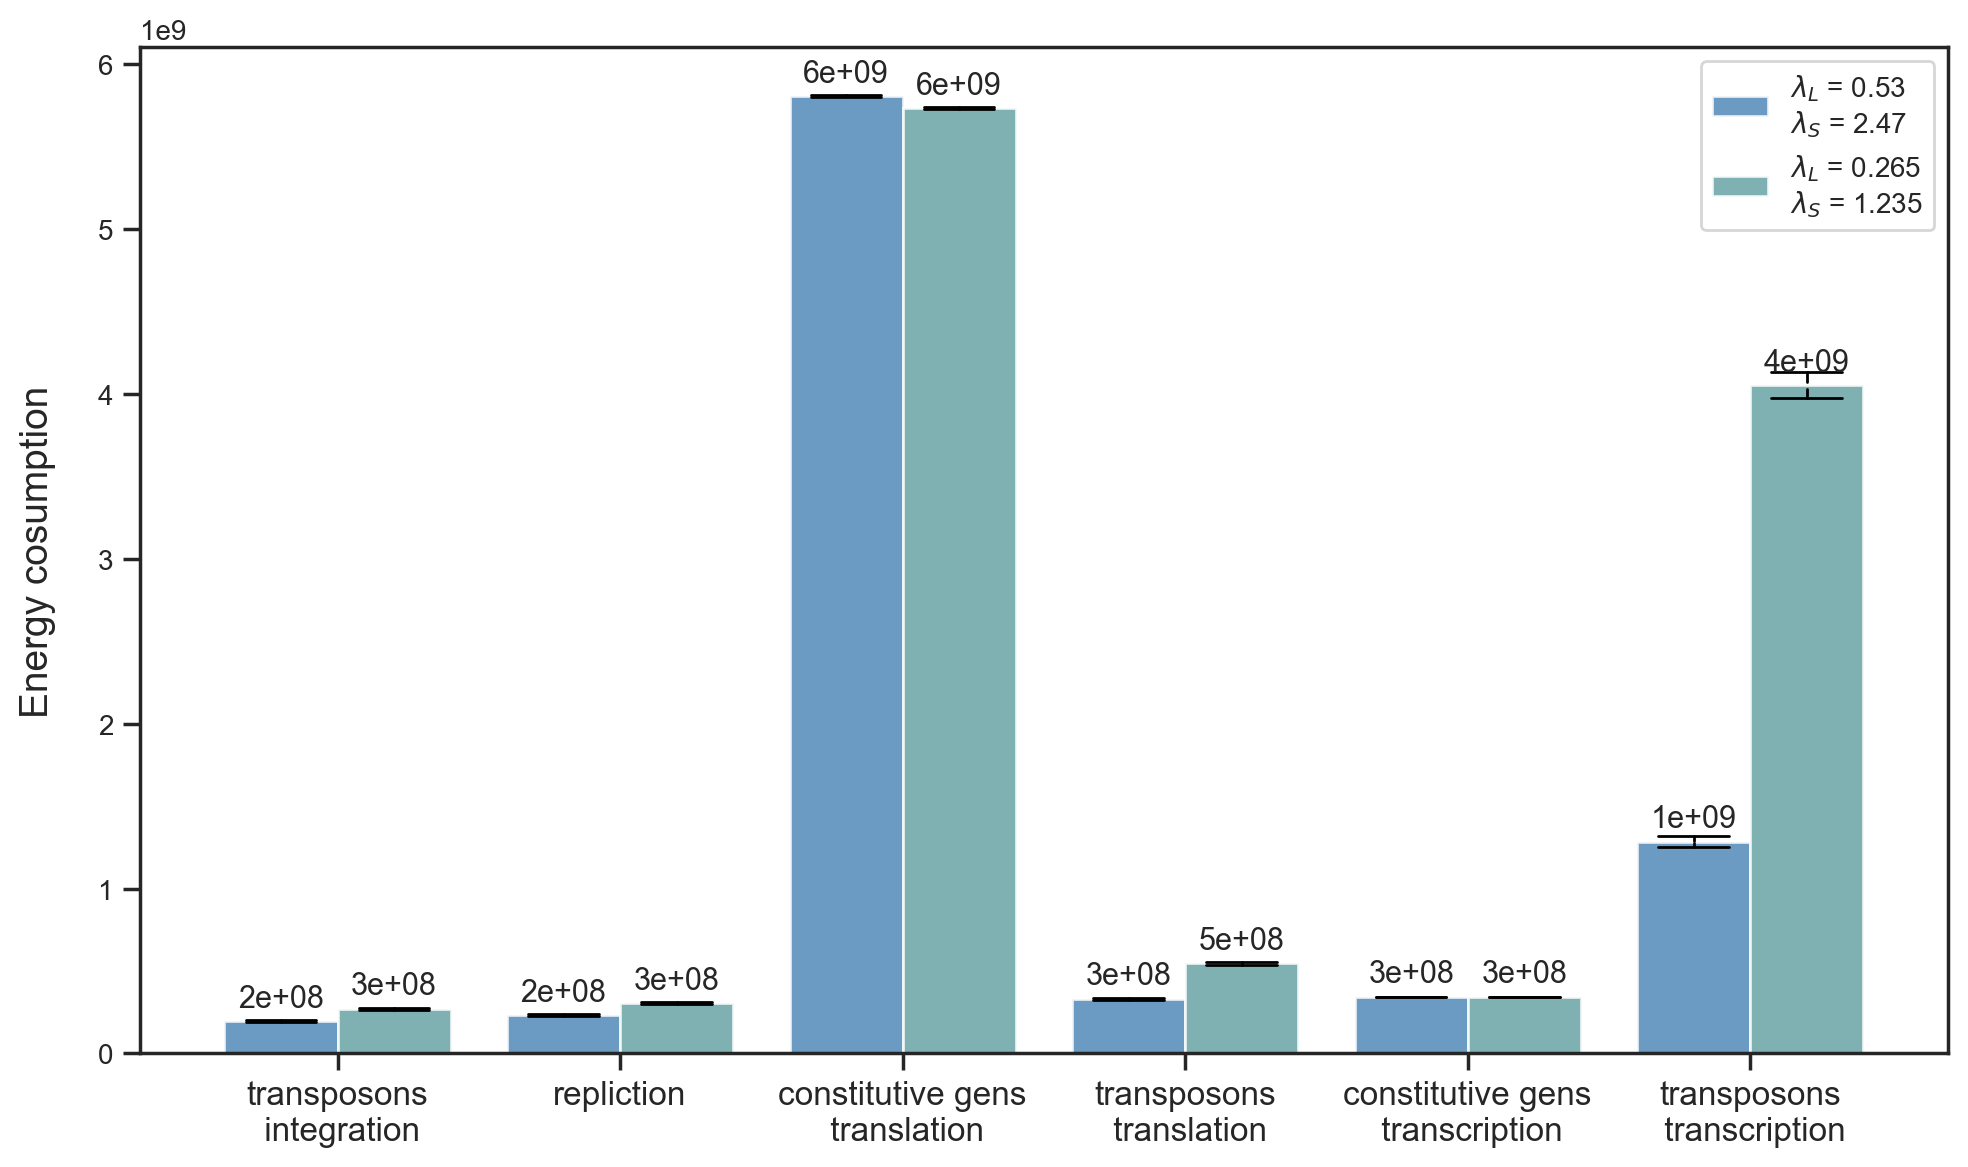

In [248]:
# Plot lmd_L bar chart of energy consumption by rates:
x_ticks = ('transposons\n integration', 'repliction', 'constitutive gens\n translation', 'transposons\n translation', 
           'constitutive gens\n transcription', 'transposons\n transcription')
bar_len = np.arange(len(x_ticks))
colors = ['peachpuff', 'orange', 'tomato','peachpuff', 'orange', 'tomato']

fig, ax = plt.subplots(figsize=(10,6))

# Rates of energy consumption::
ecr  = en_cons_rates(sty0)
ecr2 = en_cons_rates(sty4)

# # matplotlib bar (change lmd_L)
# bar  = plt.bar(x=bar_len- 0.2, height=ecr , width=0.4, align='center', alpha=0.8, 
#                label=f"{par_dict_names['lmd_L']} = {lmd_L}", color='steelblue')
# bar2 = plt.bar(x=bar_len+ 0.2, height=ecr2, width=0.4, align='center', alpha=0.8, 
#                label=f"{par_dict_names['lmd_L']} = {lmd_L/2}", color='cadetblue')

# matplotlib bar (change lmd_L and lmd_S)
bar  = plt.bar(x=bar_len- 0.2, height=ecr , width=0.4, align='center', alpha=0.8, 
               label=f"{par_dict_names['lmd_L']} = {lmd_L}\n{par_dict_names['lmd_S']} = {lmd_S}", color='steelblue')
bar2 = plt.bar(x=bar_len+ 0.2, height=ecr2, width=0.4, align='center', alpha=0.8, 
               label=f"{par_dict_names['lmd_L']} = {lmd_L/2}\n{par_dict_names['lmd_S']} = {lmd_S/2}", color='cadetblue')

bplot = ax.boxplot(en_cons[:,:],
                   positions=np.array([*range(6)])-0.2,
                   patch_artist=True,
                   showfliers=False,  
                   meanline=False,
                   showbox=False,
                  medianprops=dict(linewidth=0.)
                  ) 

bplot = ax.boxplot(en_cons2[:,:],
                   positions=np.array([*range(6)])+0.2,
                   patch_artist=True,
                   showfliers=False,  
                   meanline=False,
                   showbox=False,
                  medianprops=dict(linewidth=0.)
                  ) 

# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# Set axes
ax.bar_label(bar, fmt='%.0e', fontsize=11, padding=3)
ax.bar_label(bar2, fmt='%.0e', fontsize=11, padding=3)
ax.set_xticks(bar_len, x_ticks, fontsize=12, rotation=0)
ax.set_ylabel('Energy cosumption', labelpad=15, rotation=90)
# ax.set_yscale('log')
ax.legend() 
fig.set_tight_layout(True)

# save figure
fig_name = f"pops_gen{n_generations}_sim{n_simulations}_en_cons_lmdL_lmdS"
fig.savefig(dir_pic+f"{fig_name}.png", bbox_inches='tight')
fig.savefig(dir_pic+f"svg/{fig_name}.svg", bbox_inches='tight')
plt.show()

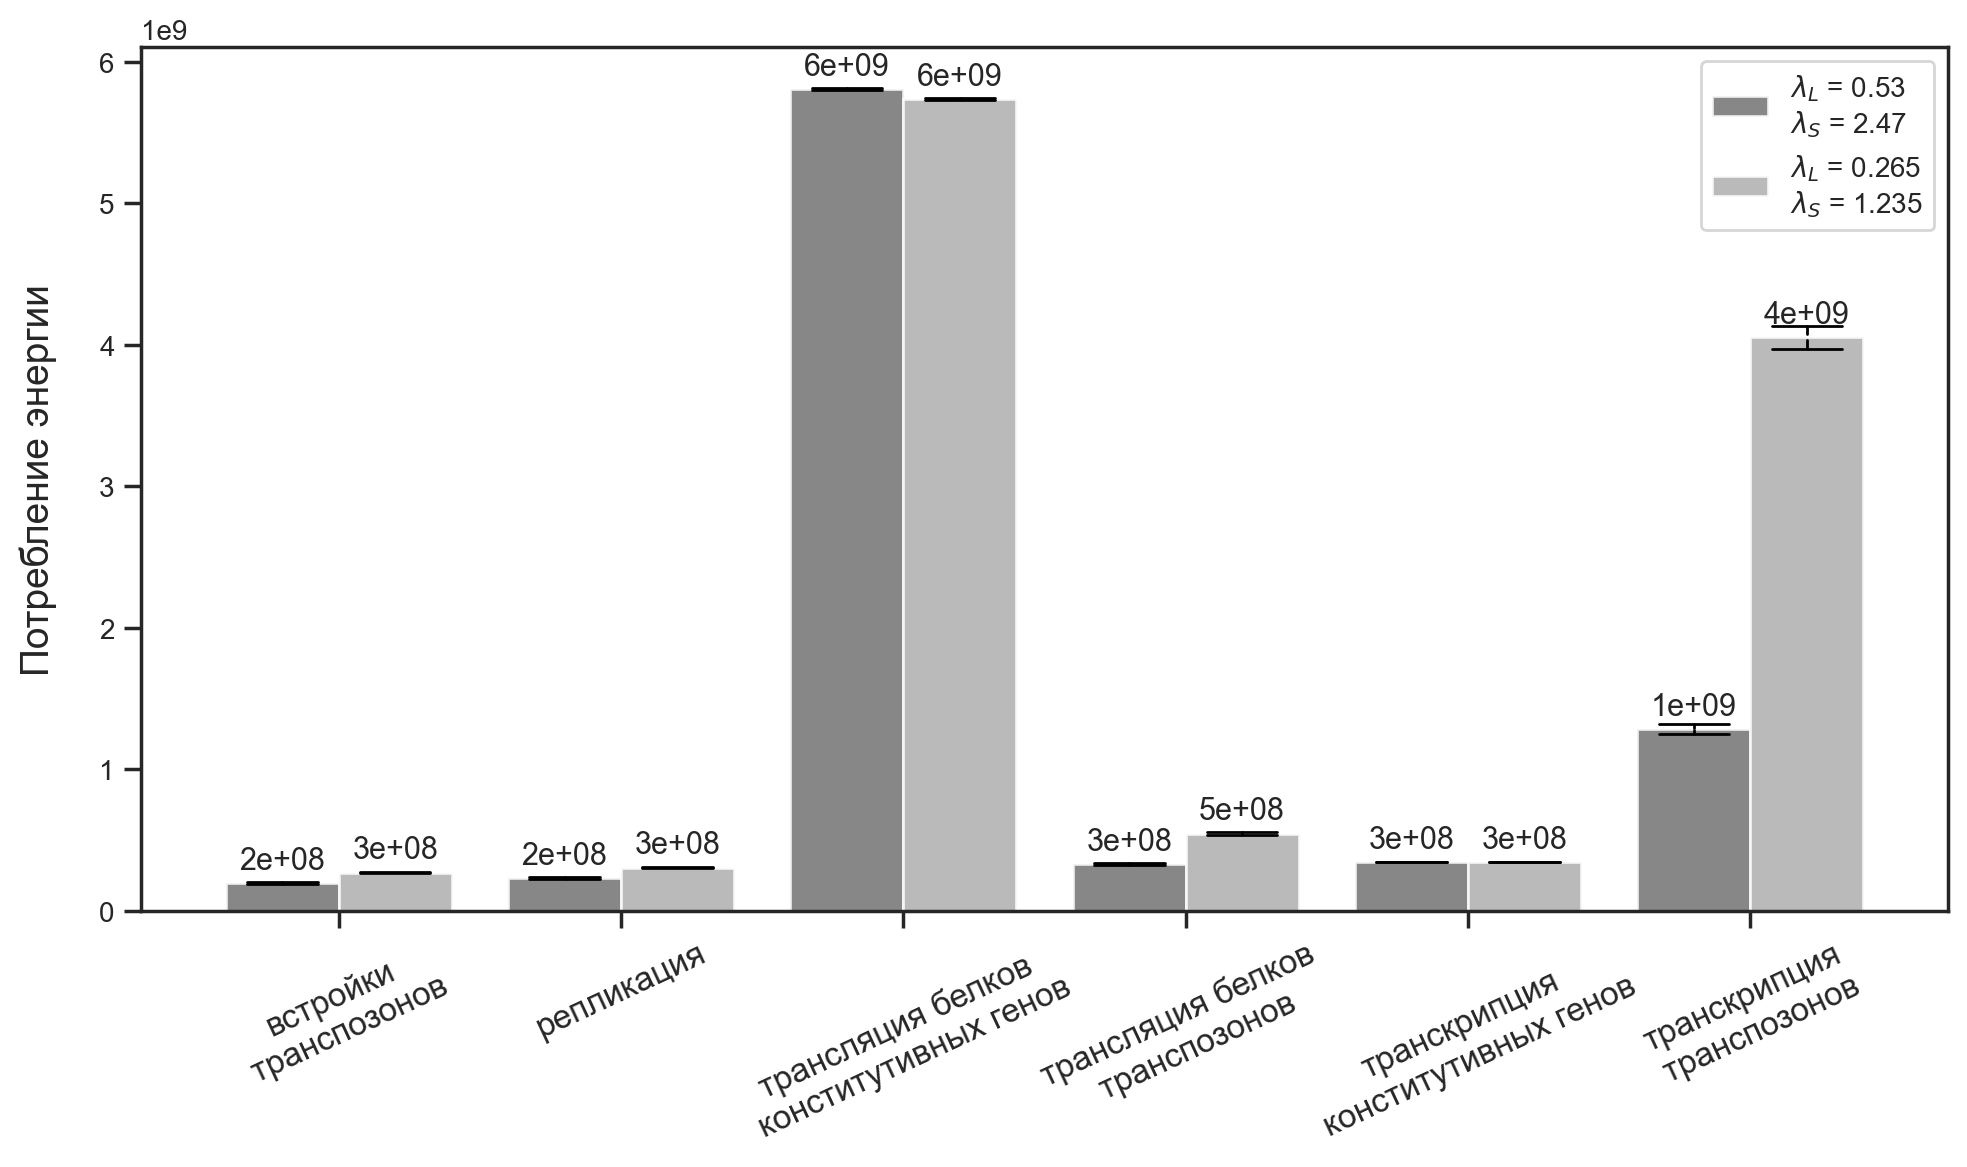

In [247]:
# Plot lmd_L bar chart of energy consumption by rates:
x_ticks = ('встройки\n транспозонов', 'репликация', 'трансляция белков\n конститутивных генов', 'трансляция белков\n транспозонов', 
           'транскрипция\n конститутивных генов', 'транскрипция\n транспозонов')
bar_len = np.arange(len(x_ticks))
colors = ['peachpuff', 'orange', 'tomato','peachpuff', 'orange', 'tomato']

fig, ax = plt.subplots(figsize=(10,6))

# Rates of energy consumption::
ecr  = en_cons_rates(sty0)
ecr2 = en_cons_rates(sty4)

# # matplotlib bar (change lmd_L)
# bar  = plt.bar(x=bar_len- 0.2, height=ecr , width=0.4, align='center', alpha=0.8, 
#                label=f"{par_dict_names['lmd_L']} = {lmd_L}", color='dimgrey')
# bar2 = plt.bar(x=bar_len+ 0.2, height=ecr2, width=0.4, align='center', alpha=0.8, 
#                label=f"{par_dict_names['lmd_L']} = {lmd_L/2}", color='darkgrey')

# matplotlib bar (change lmd_L and lmd_S)
bar  = plt.bar(x=bar_len- 0.2, height=ecr , width=0.4, align='center', alpha=0.8, 
               label=f"{par_dict_names['lmd_L']} = {lmd_L}\n{par_dict_names['lmd_S']} = {lmd_S}", color='dimgrey')
bar2 = plt.bar(x=bar_len+ 0.2, height=ecr2, width=0.4, align='center', alpha=0.8, 
               label=f"{par_dict_names['lmd_L']} = {lmd_L/2}\n{par_dict_names['lmd_S']} = {lmd_S/2}", color='darkgrey')

bplot = ax.boxplot(en_cons[:,:],
                   positions=np.array([*range(6)])-0.2,
                   patch_artist=True,
                   showfliers=False,  
                   meanline=False,
                   showbox=False,
                  medianprops=dict(linewidth=0.)
                  ) 

bplot = ax.boxplot(en_cons2[:,:],
                   positions=np.array([*range(6)])+0.2,
                   patch_artist=True,
                   showfliers=False,  
                   meanline=False,
                   showbox=False,
                  medianprops=dict(linewidth=0.)
                  ) 

# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# Set axes
ax.bar_label(bar, fmt='%.0e', fontsize=11, padding=3)
ax.bar_label(bar2, fmt='%.0e', fontsize=11, padding=3)
ax.set_xticks(bar_len, x_ticks, fontsize=12, rotation=25)
ax.set_ylabel('Потребление энергии', labelpad=15, rotation=90)
# ax.set_yscale('log')
ax.legend() 
fig.set_tight_layout(True)

# save figure
fig_name = f"pops_gen{n_generations}_sim{n_simulations}_en_cons_lmdL_lmdS_bw"
fig.savefig(dir_pic+f"{fig_name}.png", bbox_inches='tight')
fig.savefig(dir_pic+f"svg/{fig_name}.svg", bbox_inches='tight')
plt.show()

## Plot 2 hists alongside

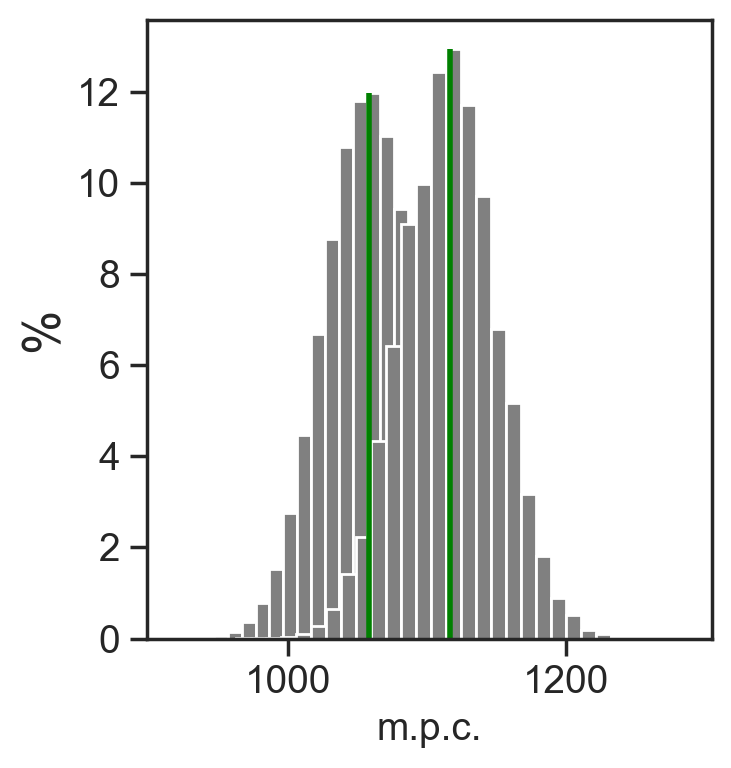

In [241]:
# Plot histograms for both models alongside
i=10 # LINE
n_bins = 30
weights = np.repeat(100/p_num,p_num)

# Plot
fig,ax = plt.subplots(1,figsize=(4,4))
hist = ax.hist(pops_tot[:,i], density=False, bins=n_bins, weights=weights, color='gray')
ax.vlines(x=mean[i], ymin=0, ymax=hist[0].max(), lw=2, color='green')
hist2 = ax.hist(pops2_tot[:,i], density=False, bins=n_bins, weights=weights, color='gray')
ax.vlines(x=mean2[i], ymin=0, ymax=hist2[0].max(), lw=2, color='green')
# ax.set_title("ATP")
ax.set_ylabel('%', fontsize=18)
ax.set_xlabel('m.p.c.')
ax.tick_params(axis='both', labelsize=14)
fig.set_tight_layout(True)
plt.show()